<a href="https://colab.research.google.com/github/mohammadbadi/Clustering_Frequency/blob/main/Code%20Sections/5.5%20KMeans%20Feature%20Importance%20%26%205.6%20K-Elbow.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total Feature Set Combinations Produced: 36
Set 1: ['OCC_YEAR', 'OCC_DAY', 'OCC_DOY', 'OCC_MONTH_Num', 'OCC_HOUR', 'OCC_DOW_Num', 'LONG_LAT_PCA', 'Division_Freq', 'LOCATION_Freq']
Set 2: ['OCC_YEAR', 'OCC_DAY', 'OCC_DOY', 'OCC_MONTH_Num', 'OCC_HOUR', 'OCC_DOW_Num', 'LONG_LAT_PCA', 'Division_Freq', 'PREMISES_Freq']
Set 3: ['OCC_YEAR', 'OCC_DAY', 'OCC_DOY', 'OCC_MONTH_Num', 'OCC_HOUR', 'OCC_DOW_Num', 'LONG_LAT_PCA', 'Division_Freq', 'Loca_Premi_Freq']
Set 4: ['OCC_YEAR', 'OCC_DAY', 'OCC_DOY', 'OCC_MONTH_Num', 'OCC_HOUR', 'OCC_DOW_Num', 'LONG_LAT_PCA', 'HOOD_Freq', 'LOCATION_Freq']
Set 5: ['OCC_YEAR', 'OCC_DAY', 'OCC_DOY', 'OCC_MONTH_Num', 'OCC_HOUR', 'OCC_DOW_Num', 'LONG_LAT_PCA', 'HOOD_Freq', 'PREMISES_Freq']
Set 6: ['OCC_YEAR', 'OCC_DAY', 'OCC_DOY', 'OCC_MONTH_Num', 'OCC_HOUR', 'OCC_DOW_Num', 'LONG_LAT_PCA', 'HOOD_Freq', 'Loca_Premi_Freq']
Set 7: ['OCC_YEAR', 'OCC_DAY', 'OCC_DOY', 'OCC_MONTH_Num', 'OCC_HOUR', 'OCC_DOW_Num', 'LONG_LAT_PCA', 'DIV_HOOD_Hier', 'LOCATION_Freq']
Set 8: ['OCC

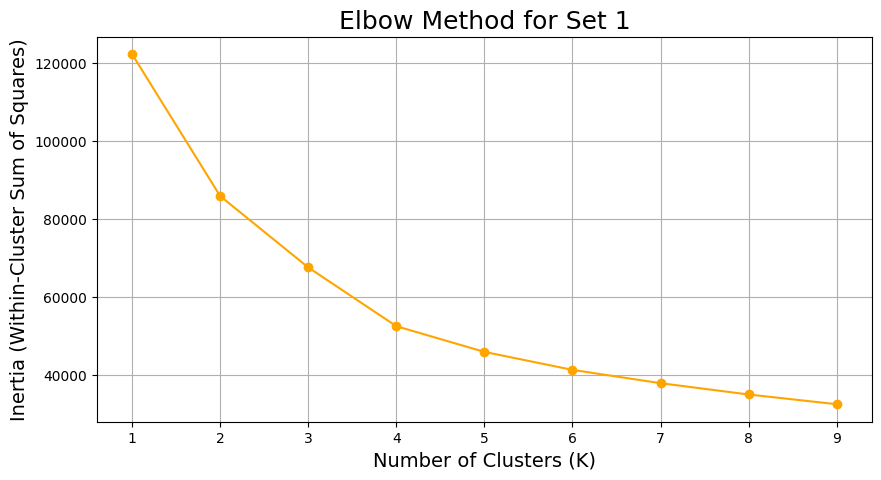

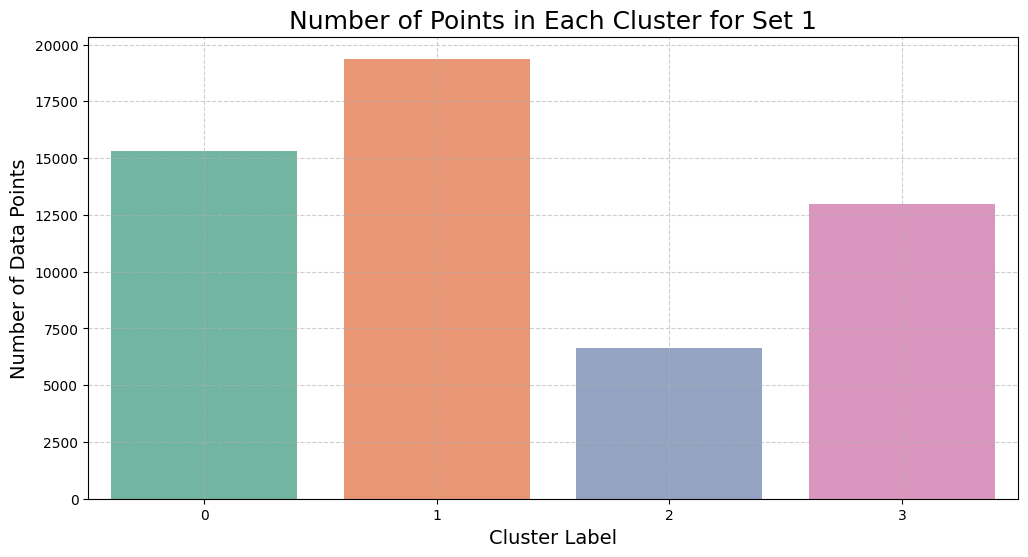

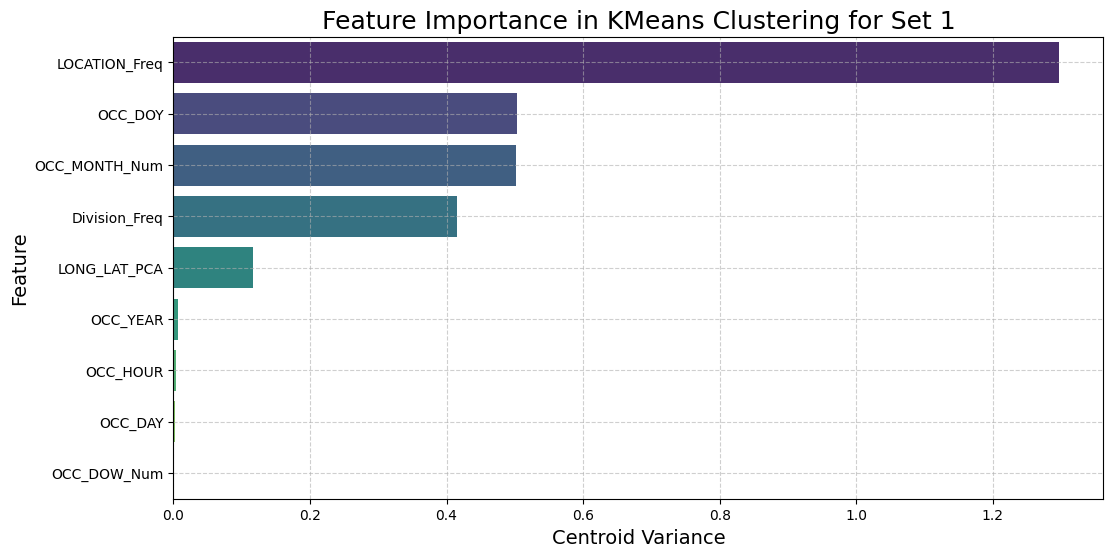

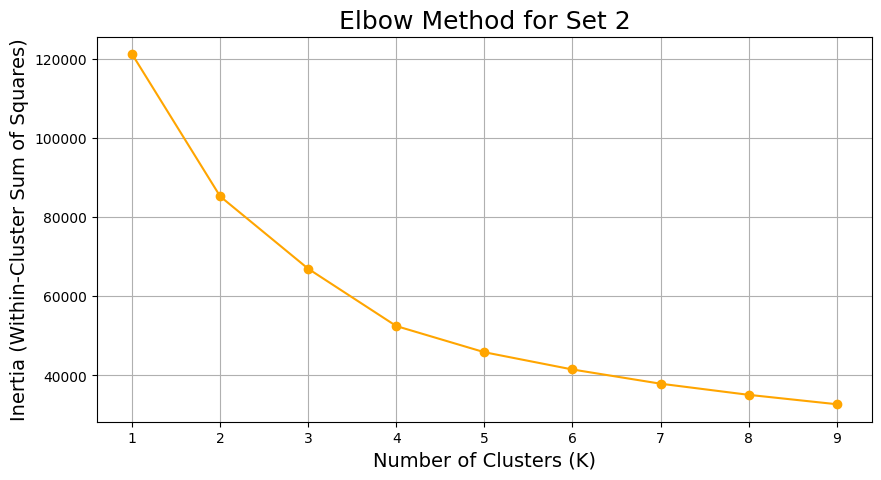

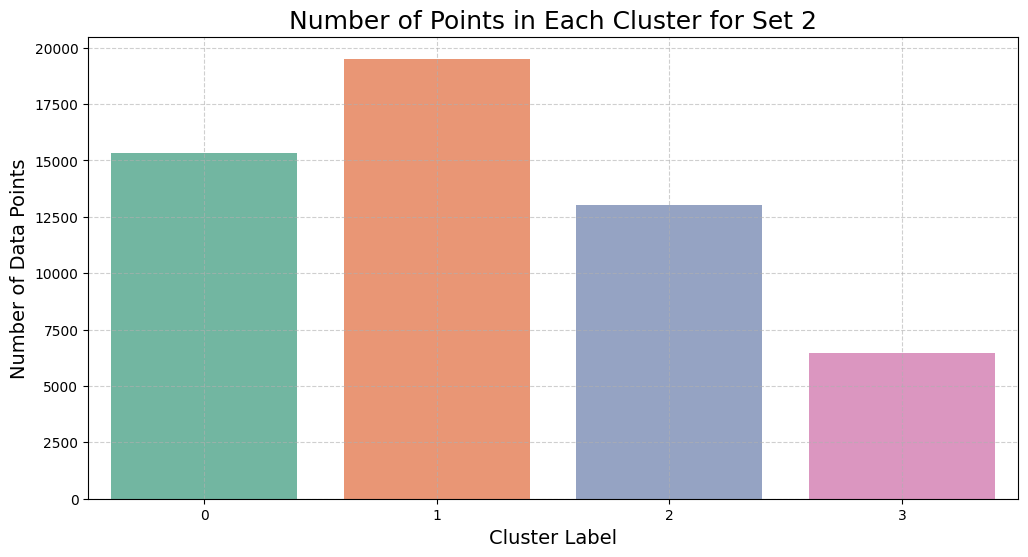

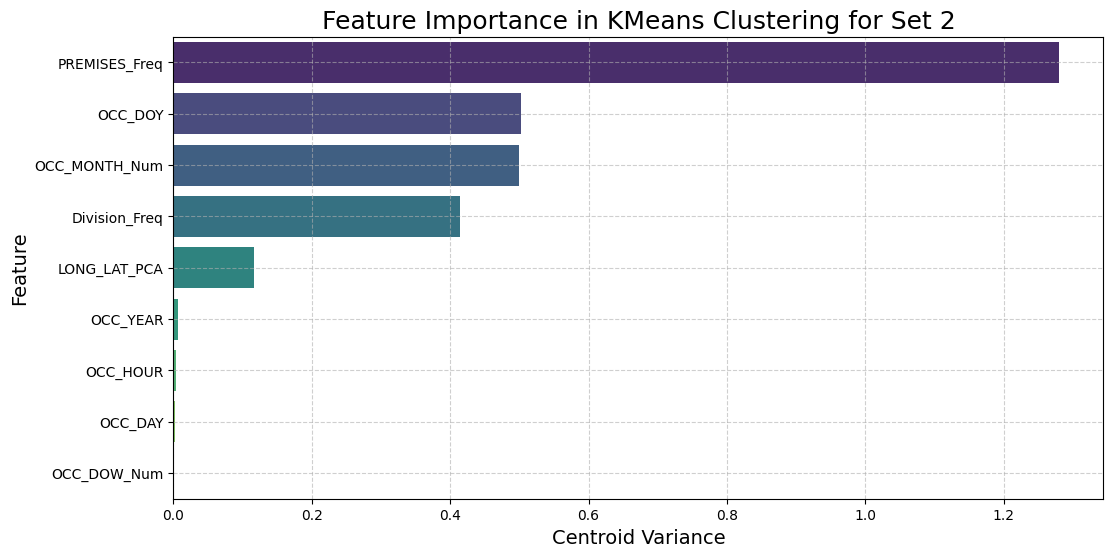

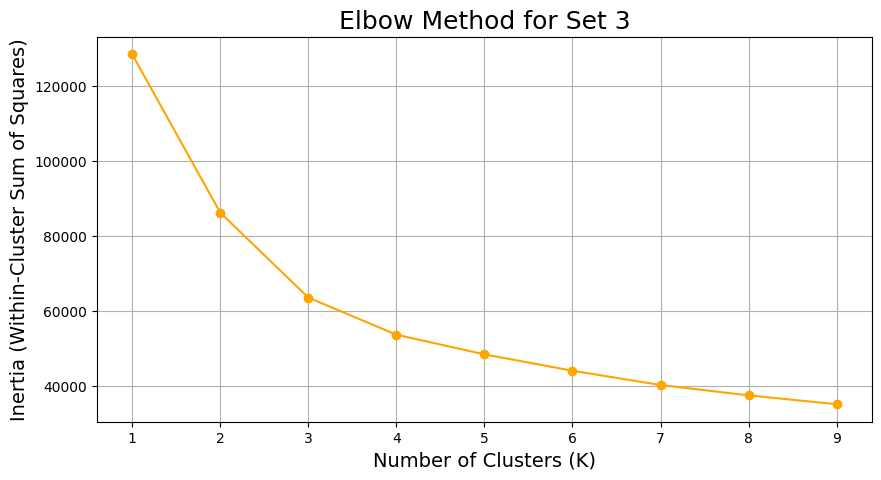

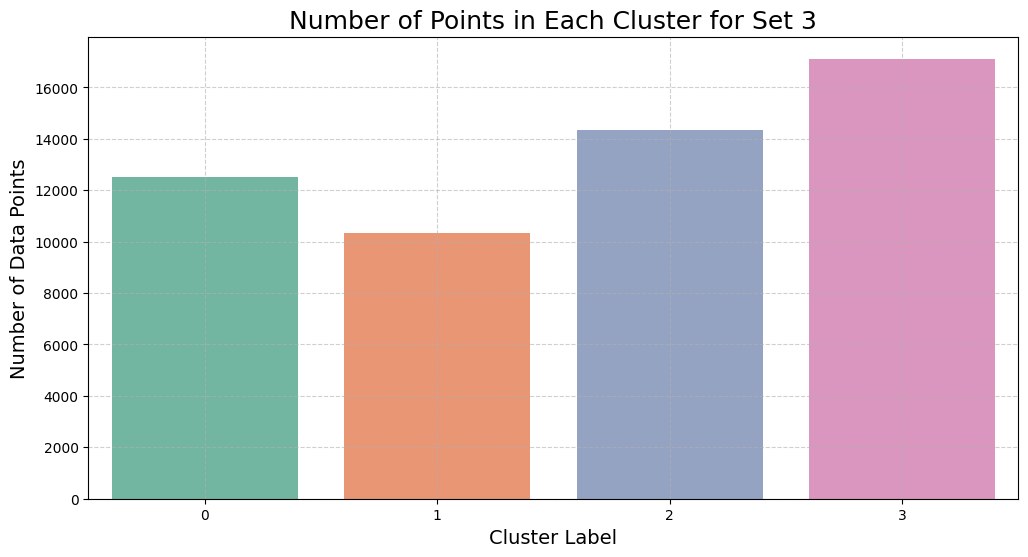

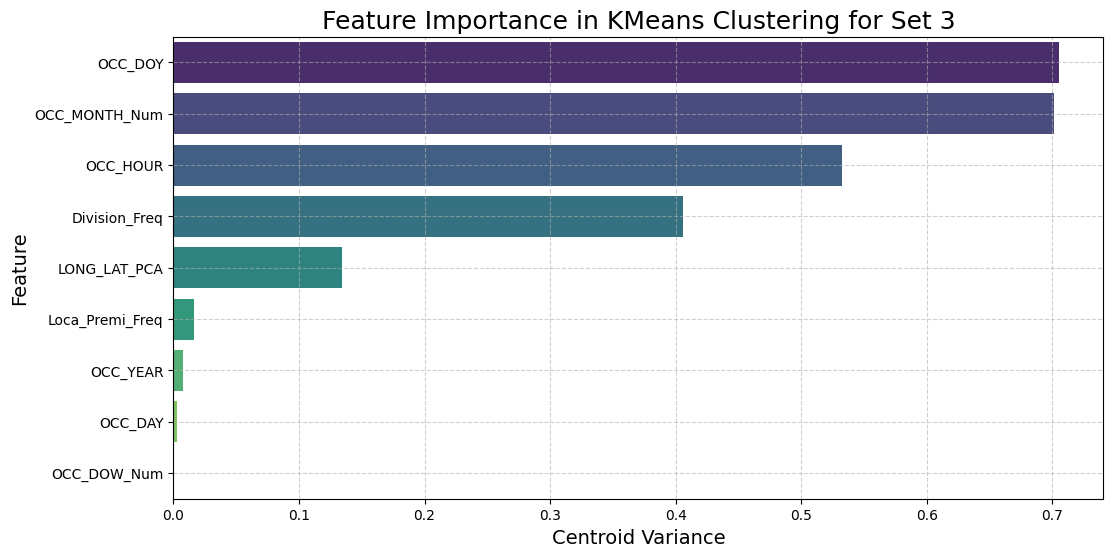

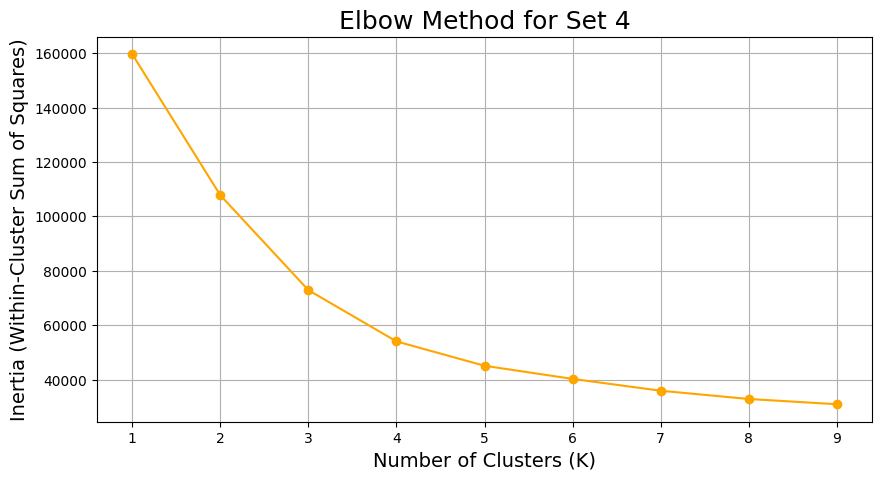

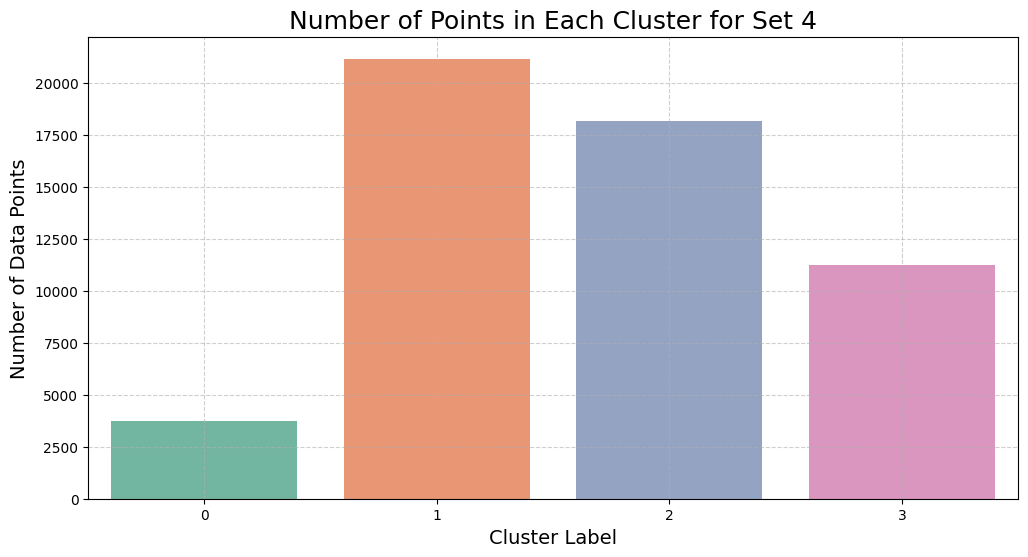

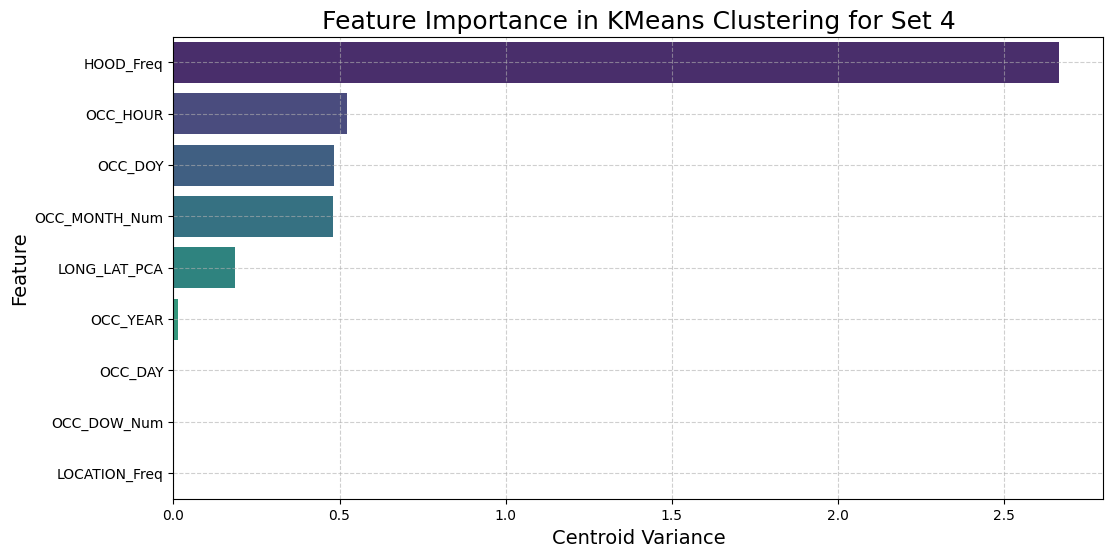

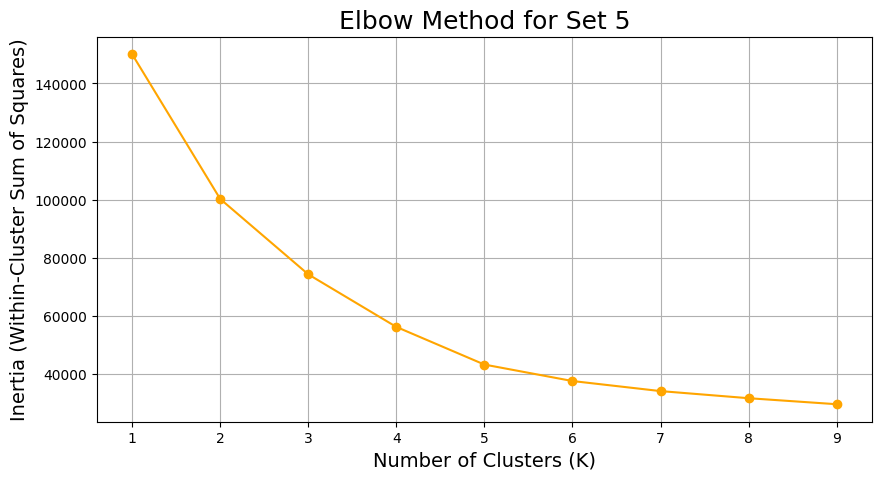

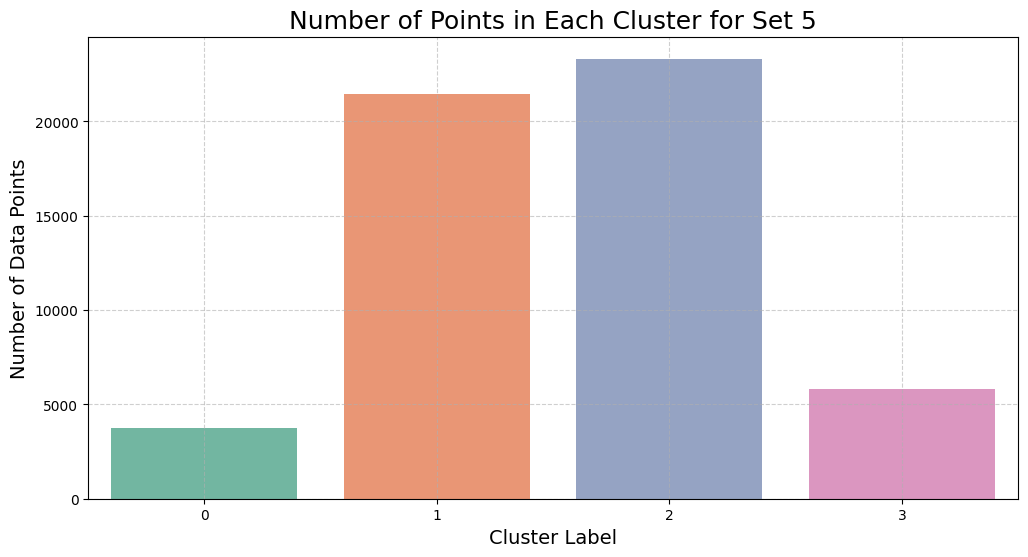

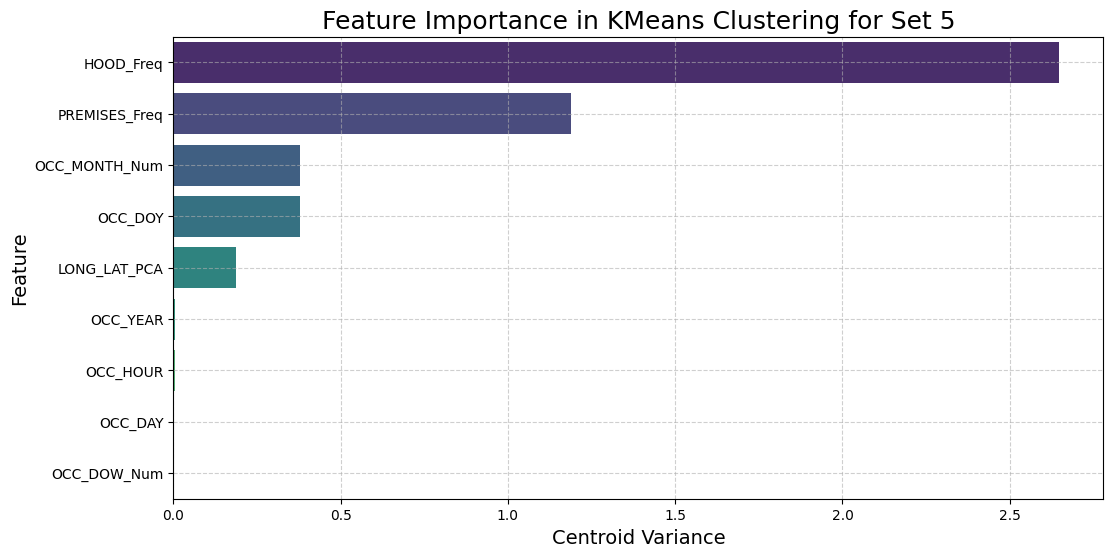

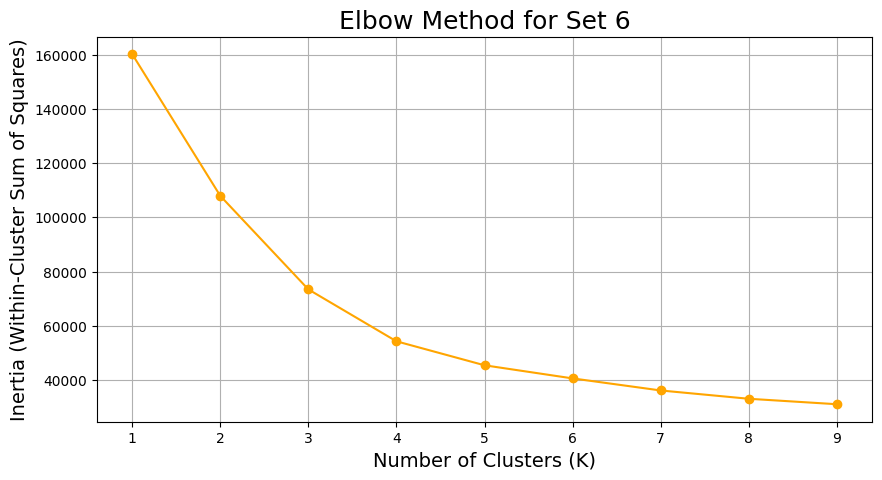

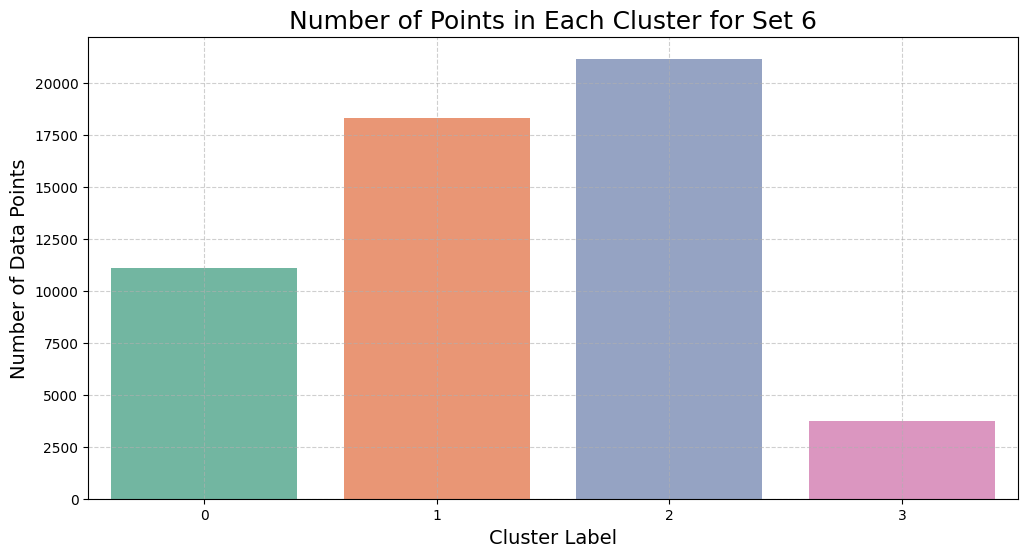

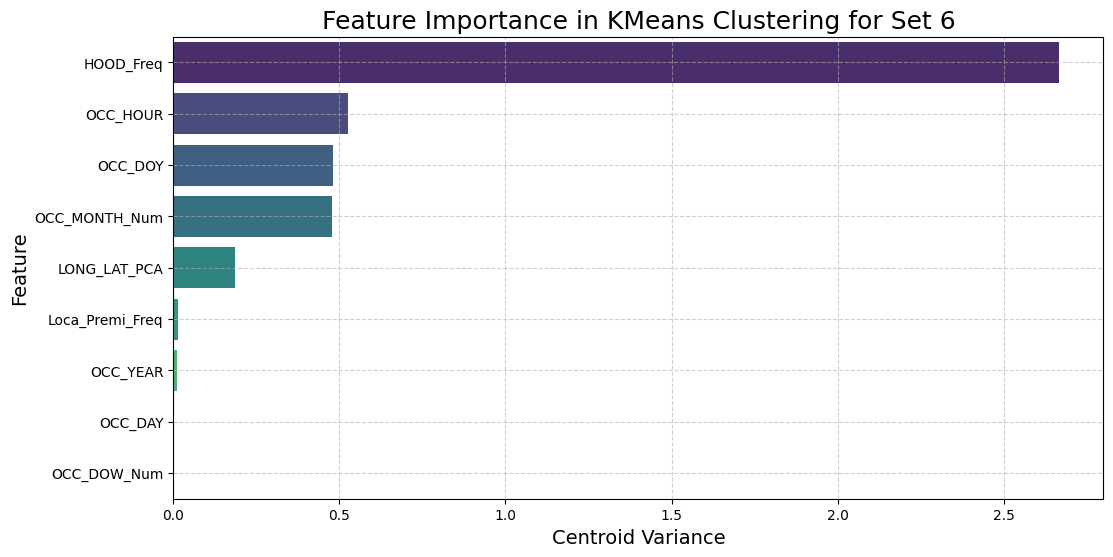

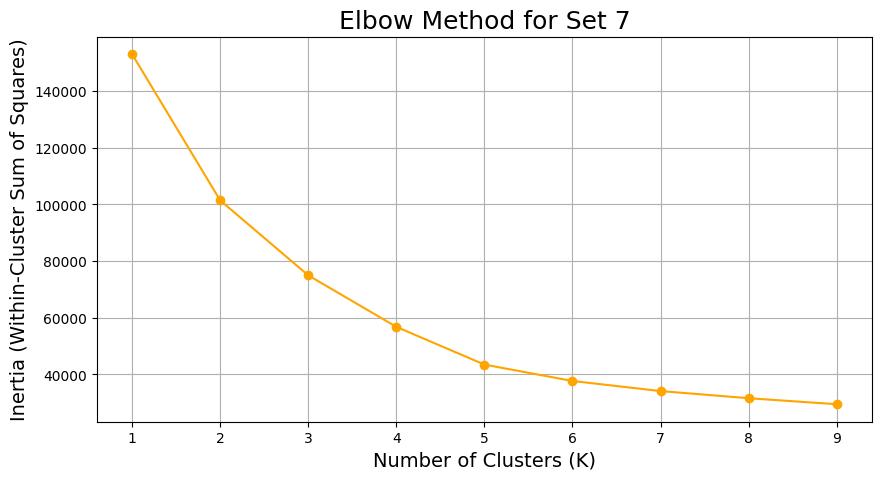

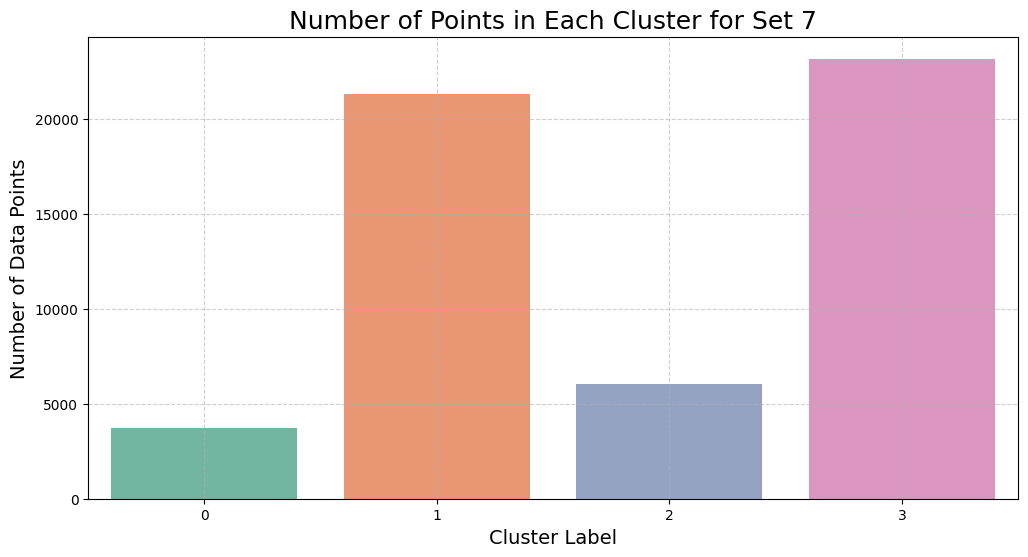

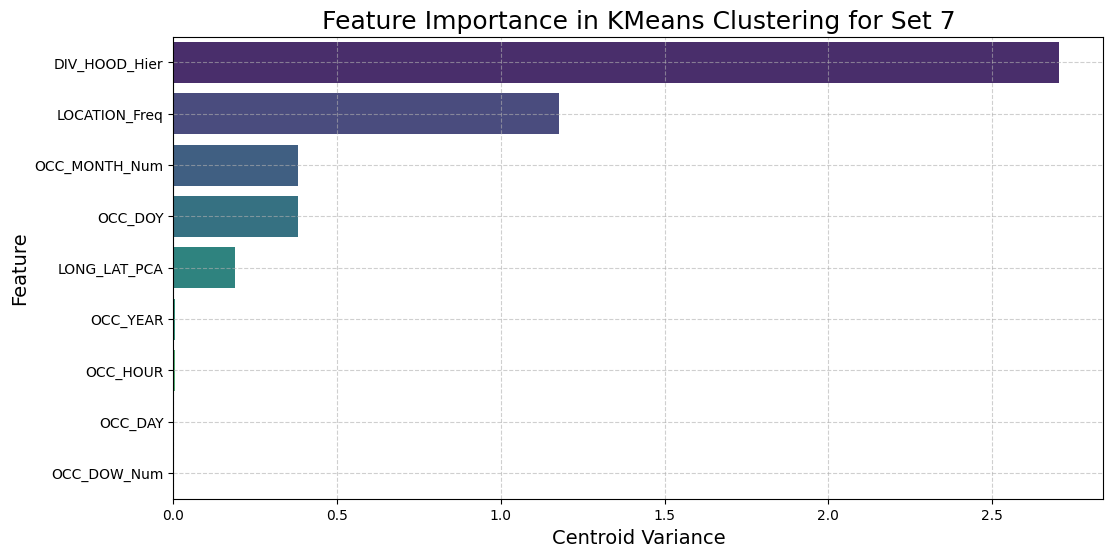

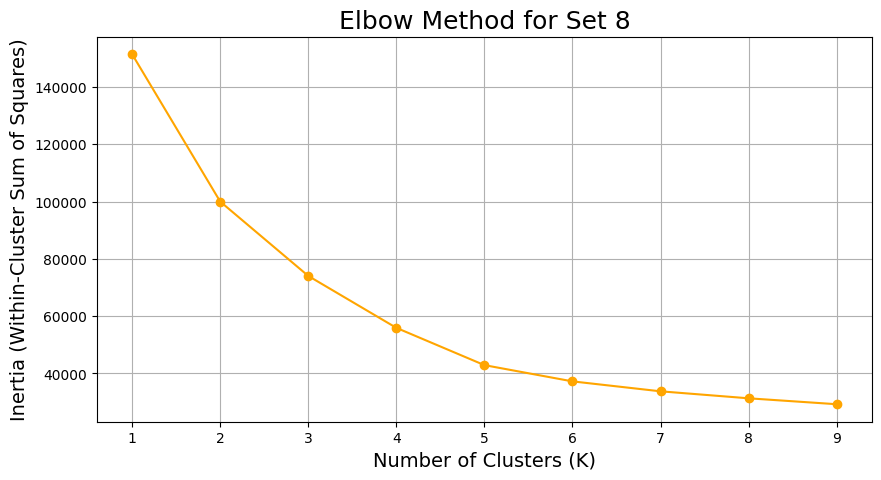

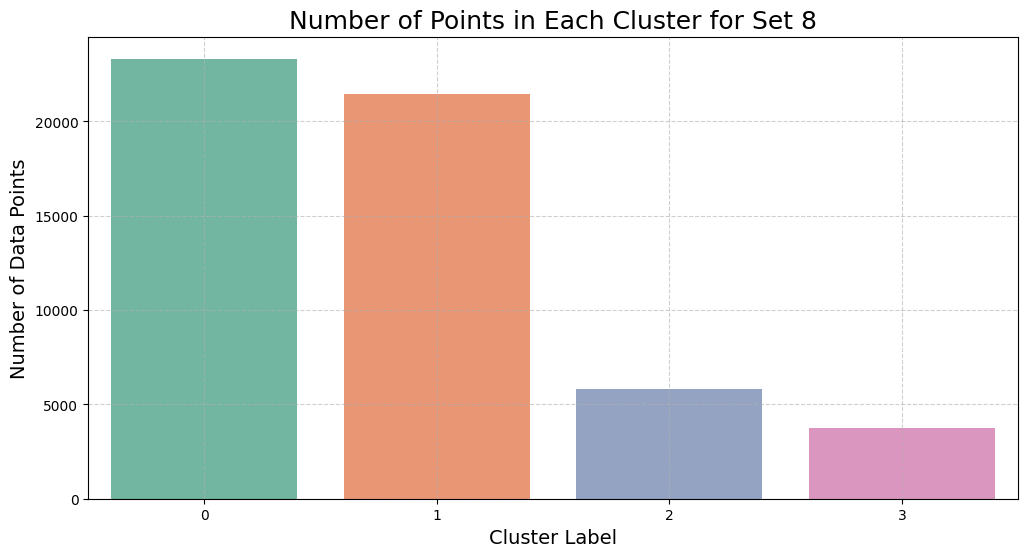

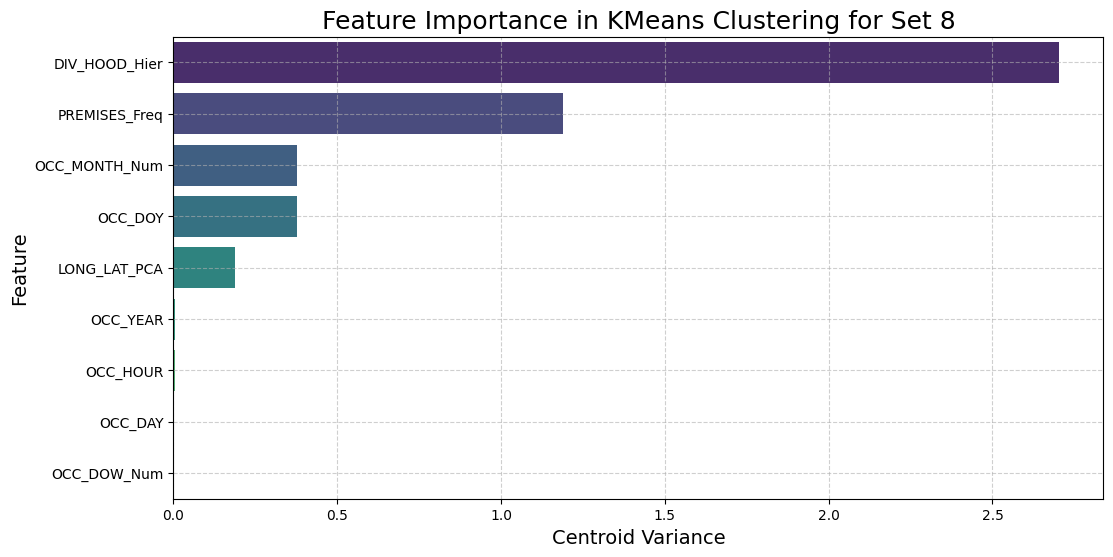

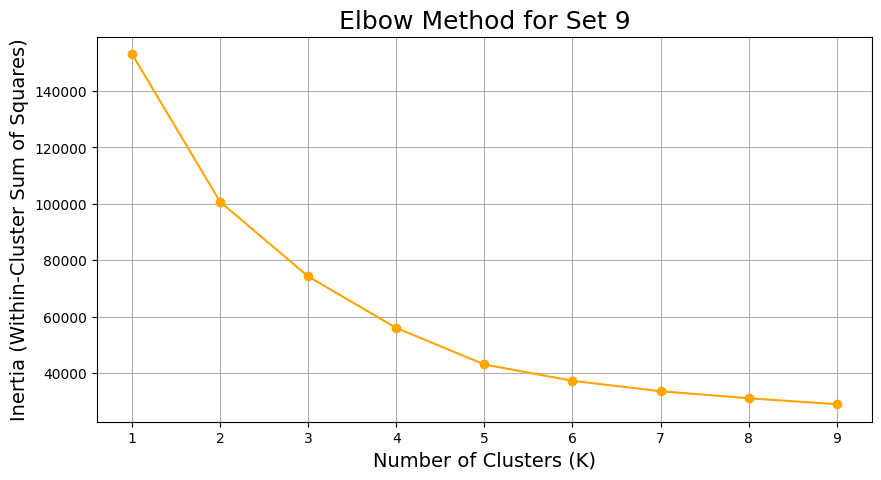

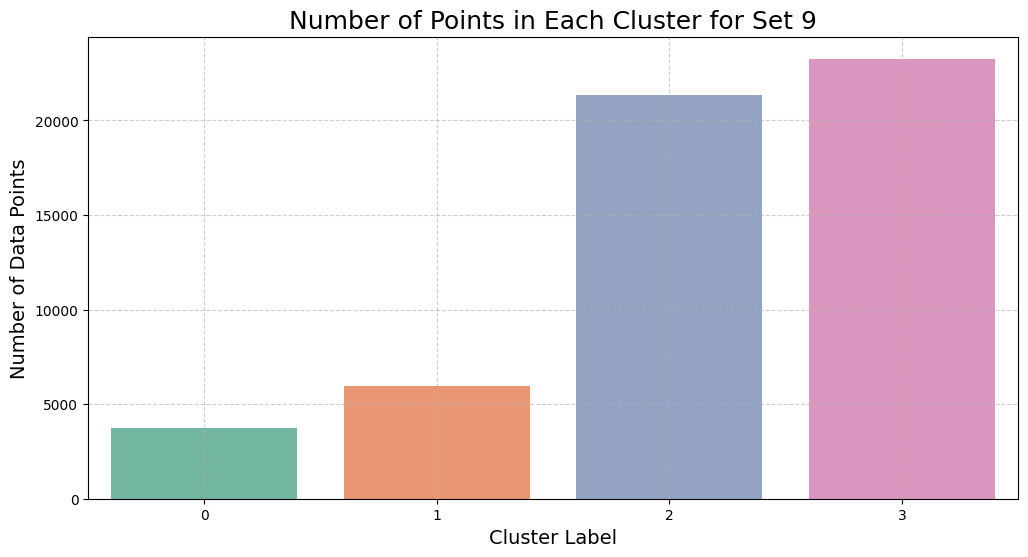

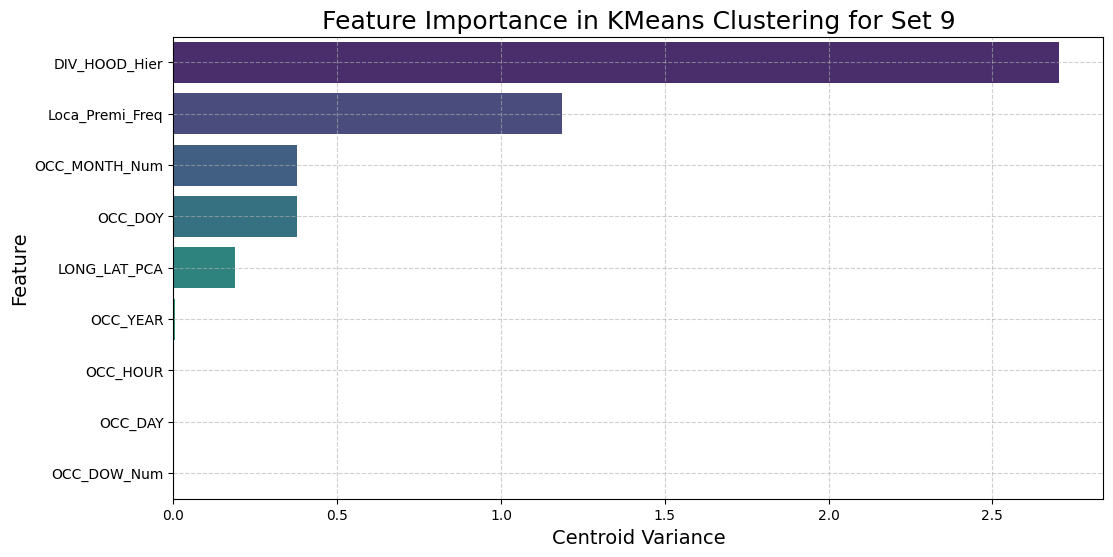

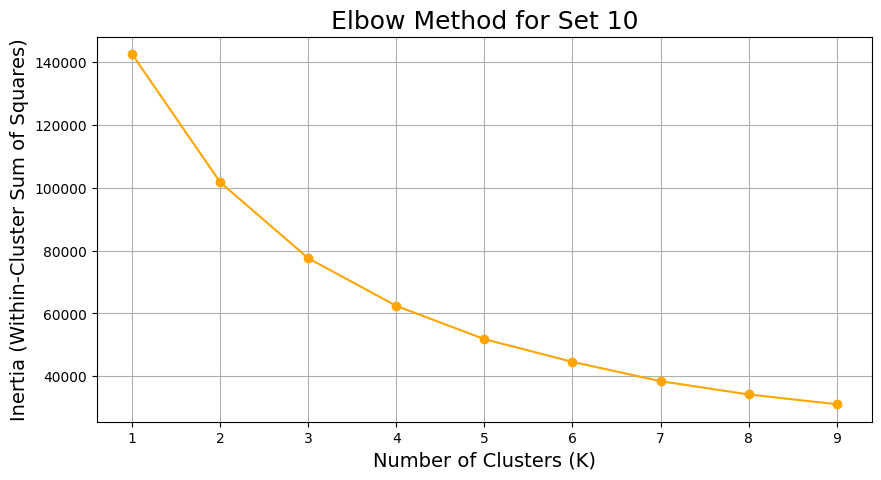

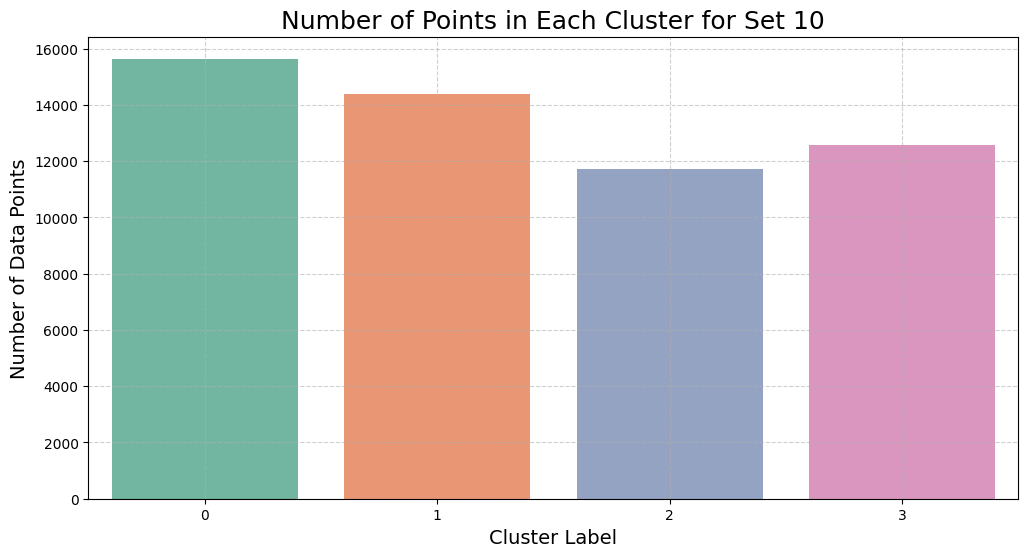

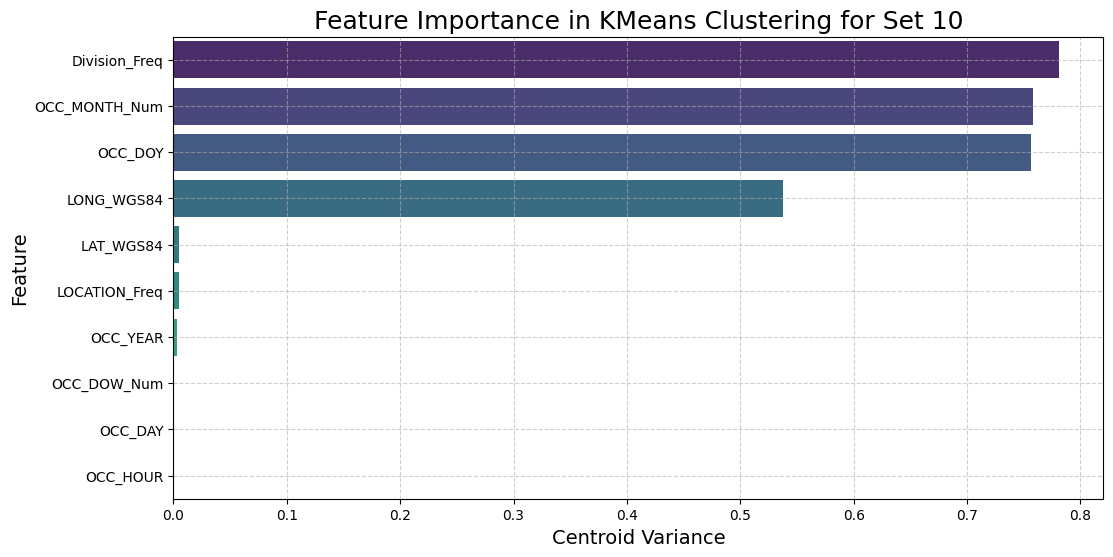

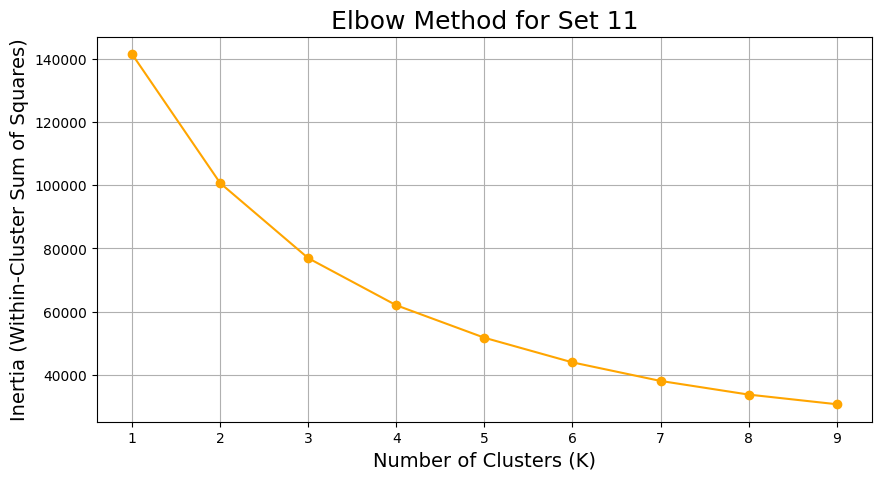

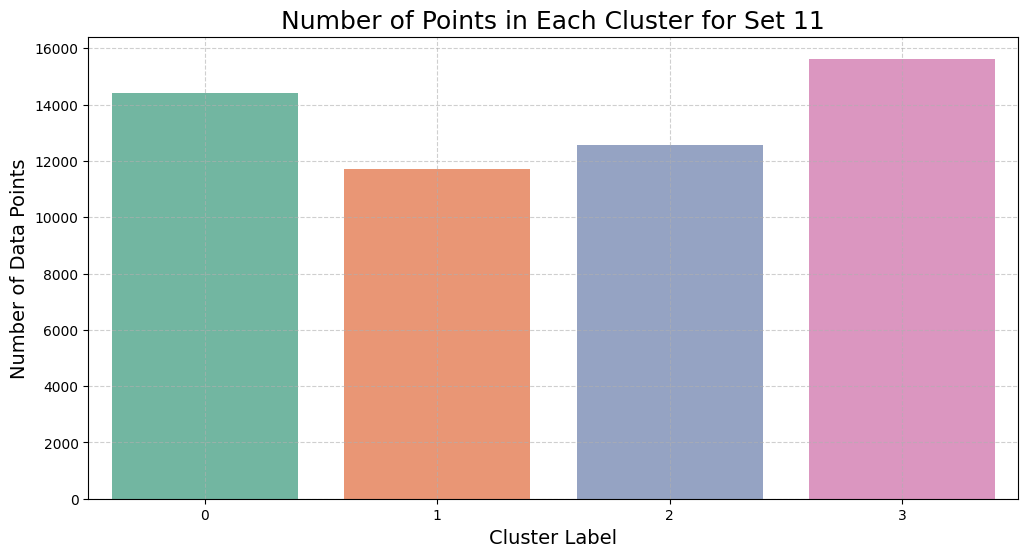

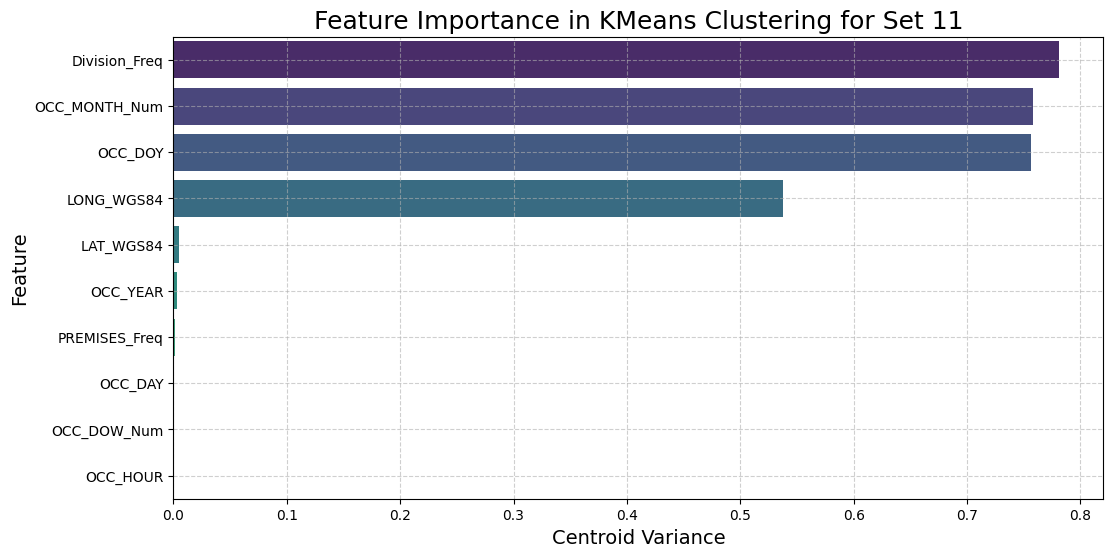

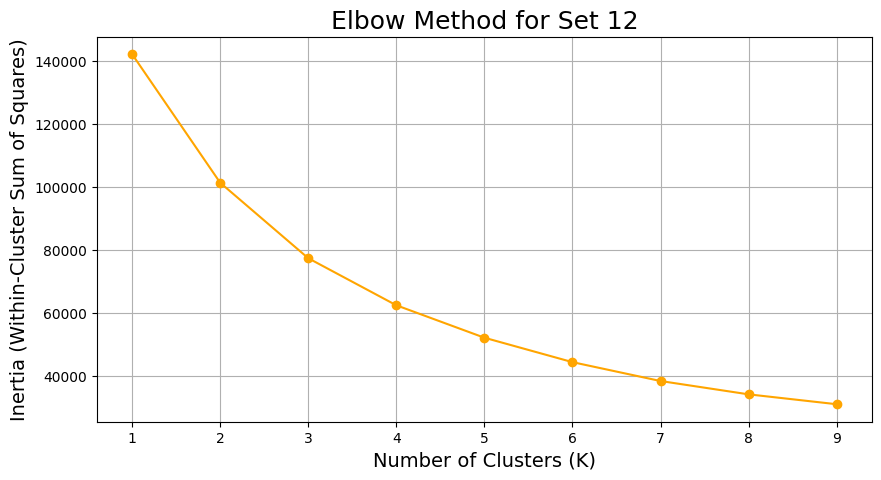

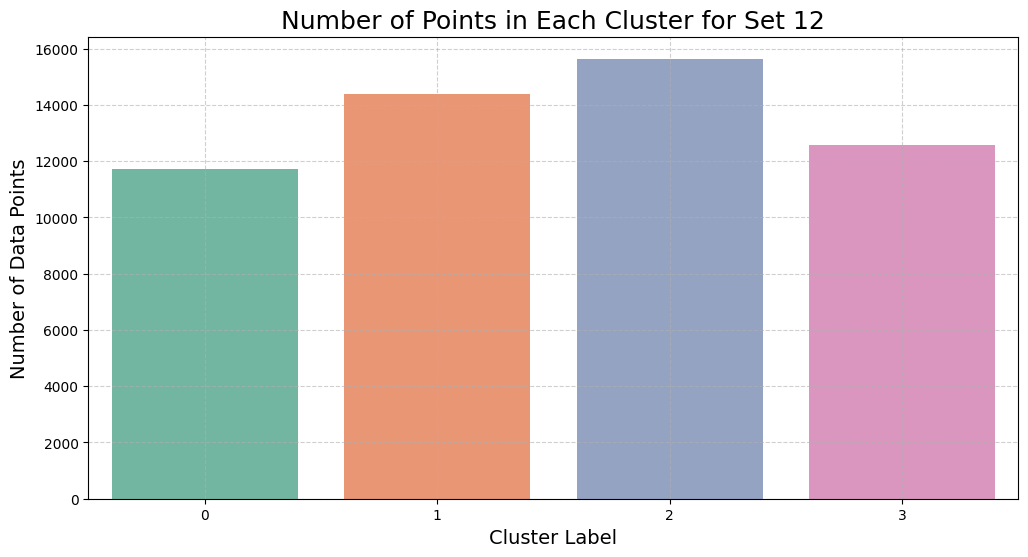

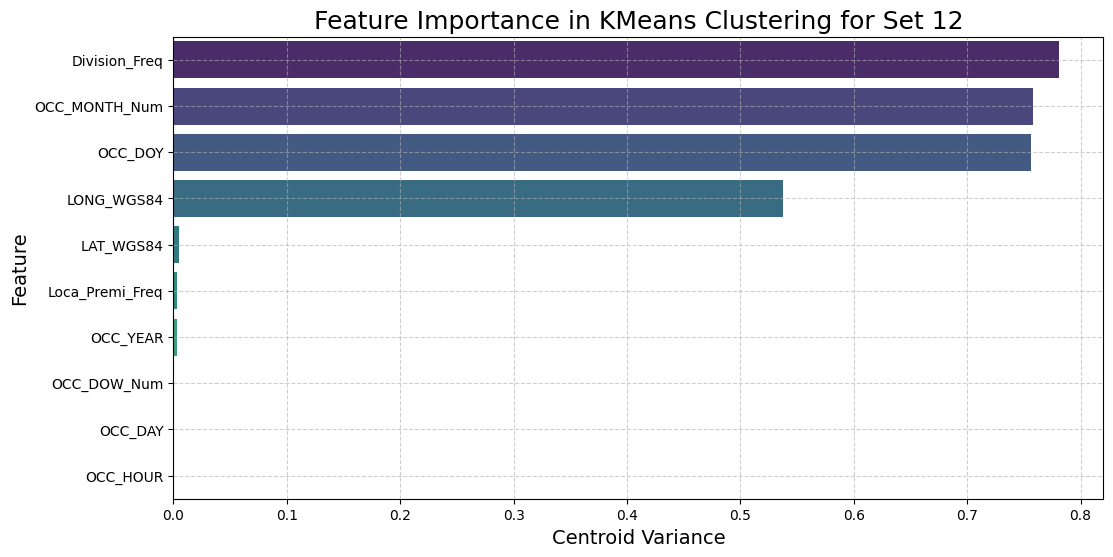

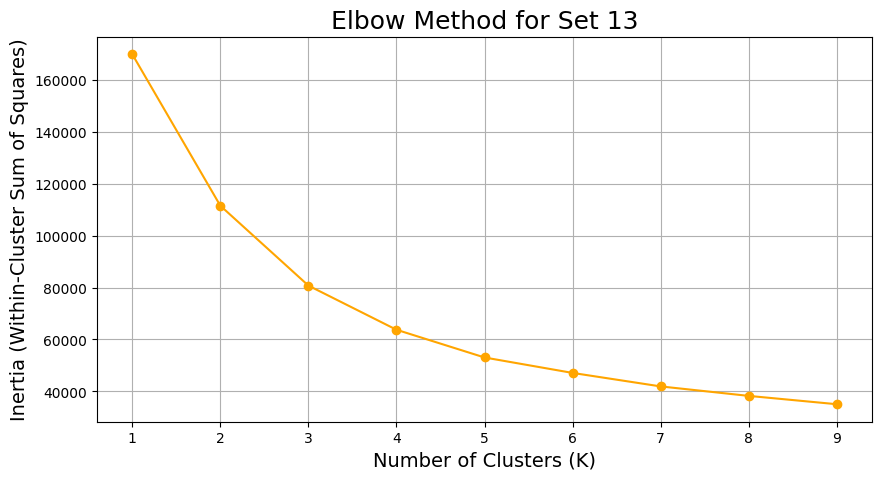

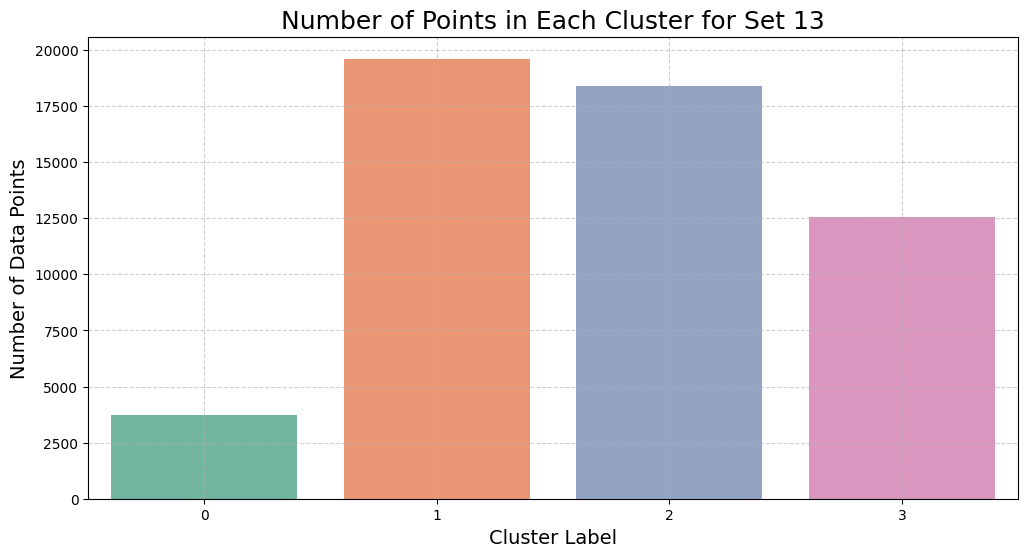

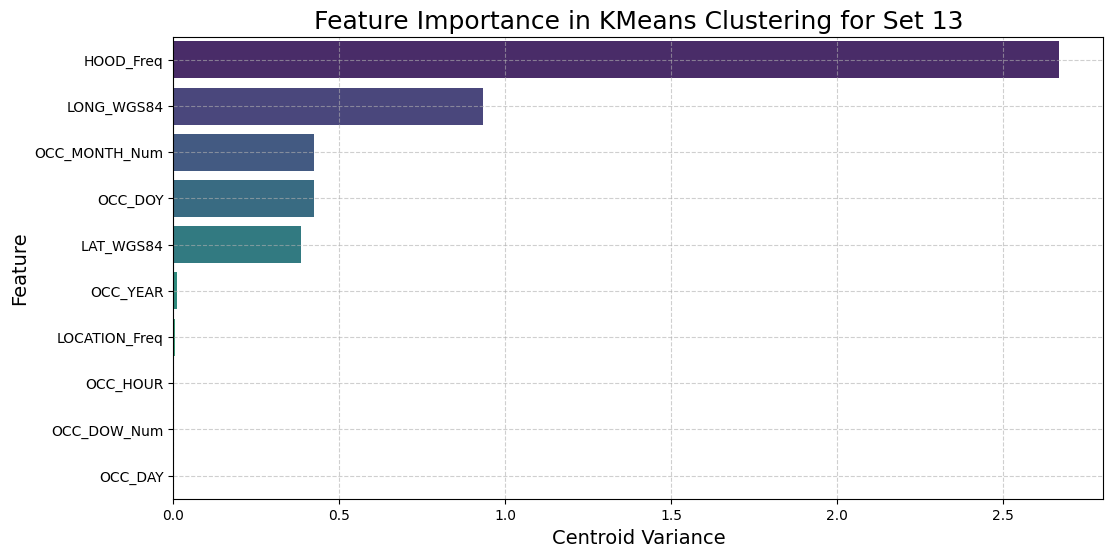

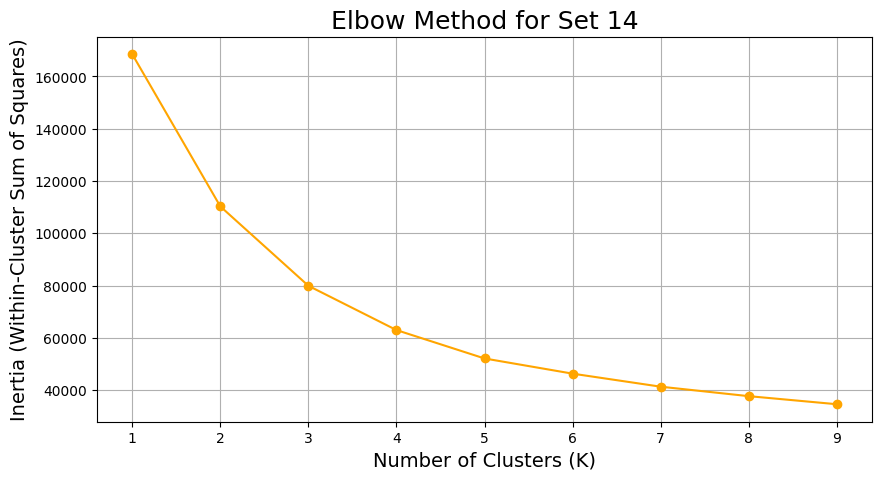

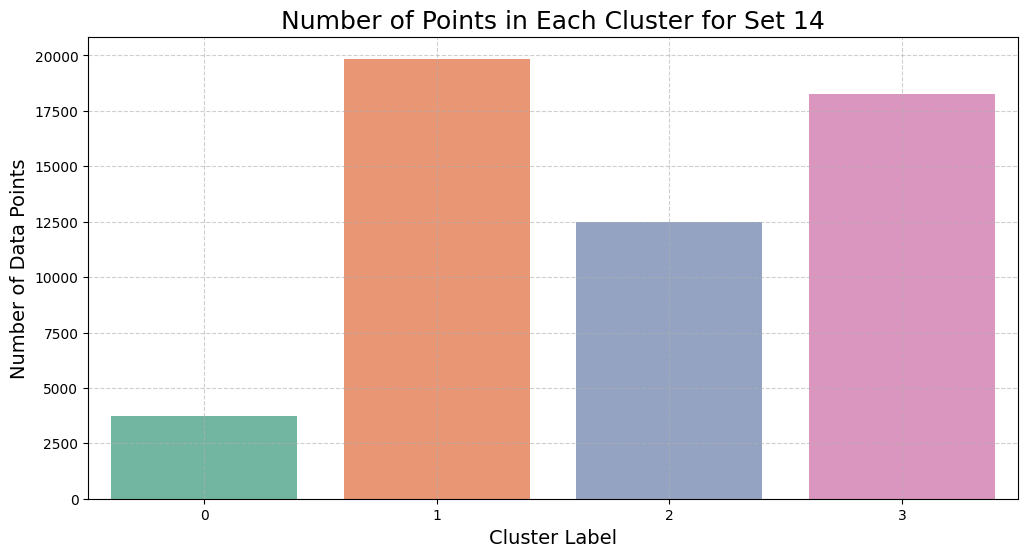

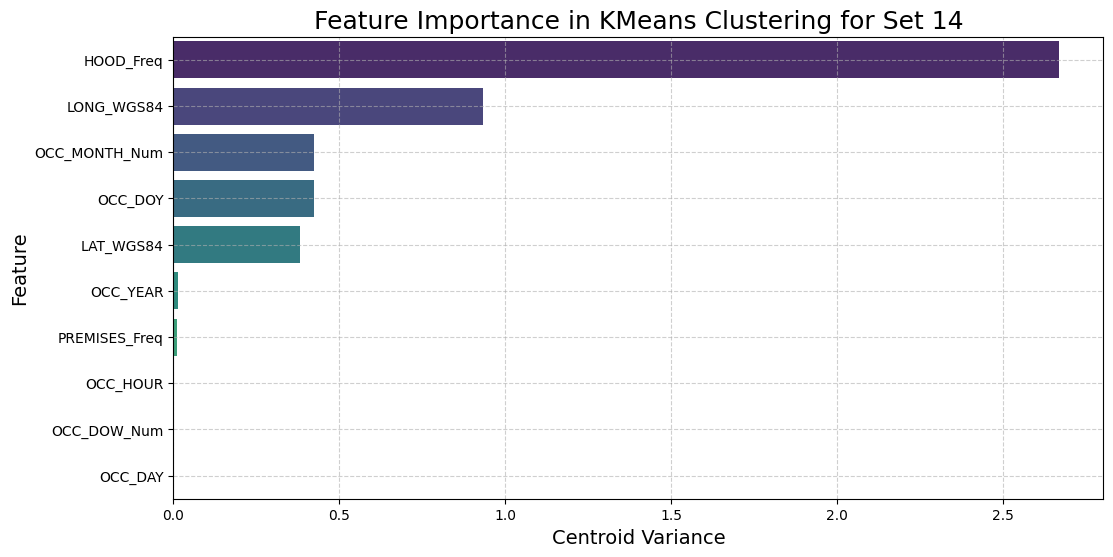

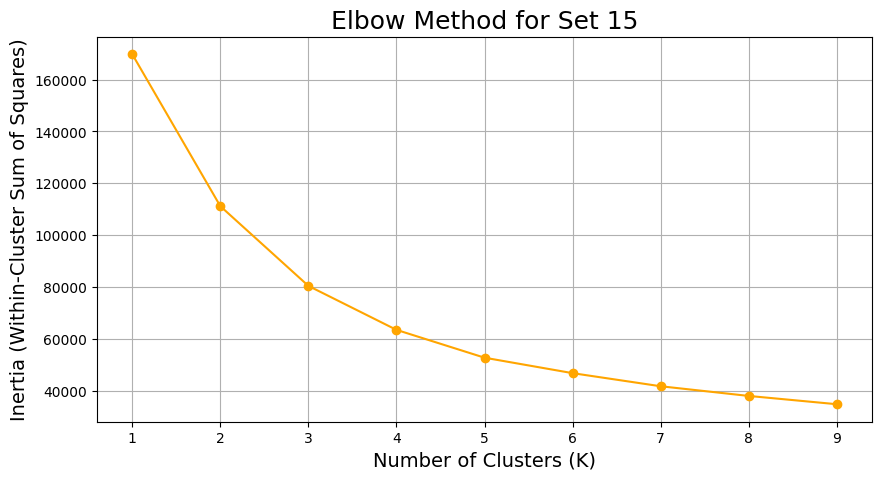

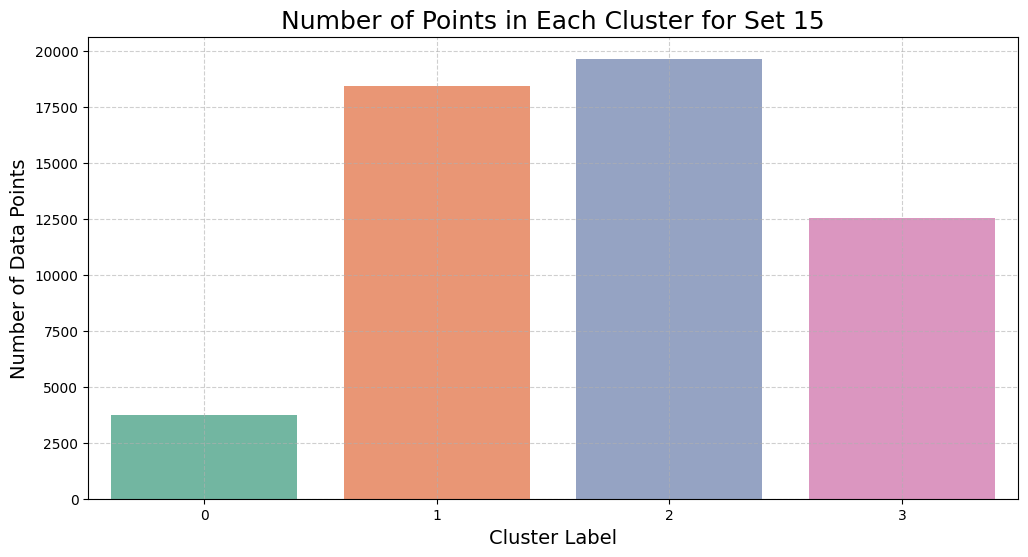

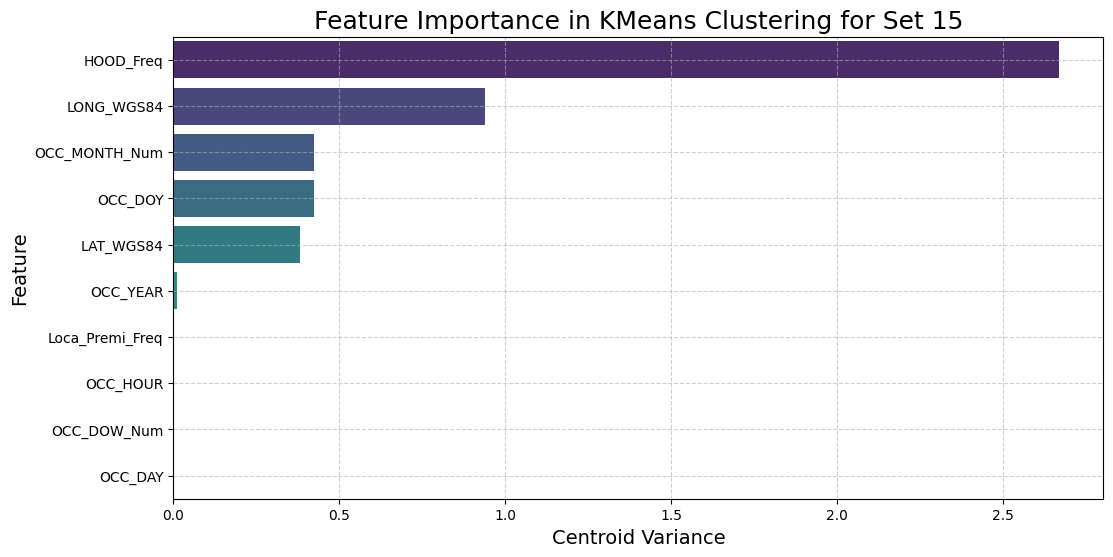

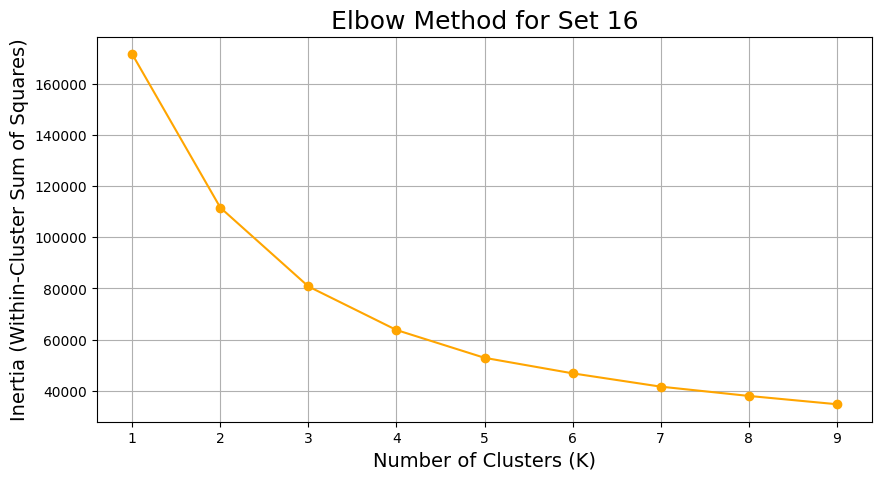

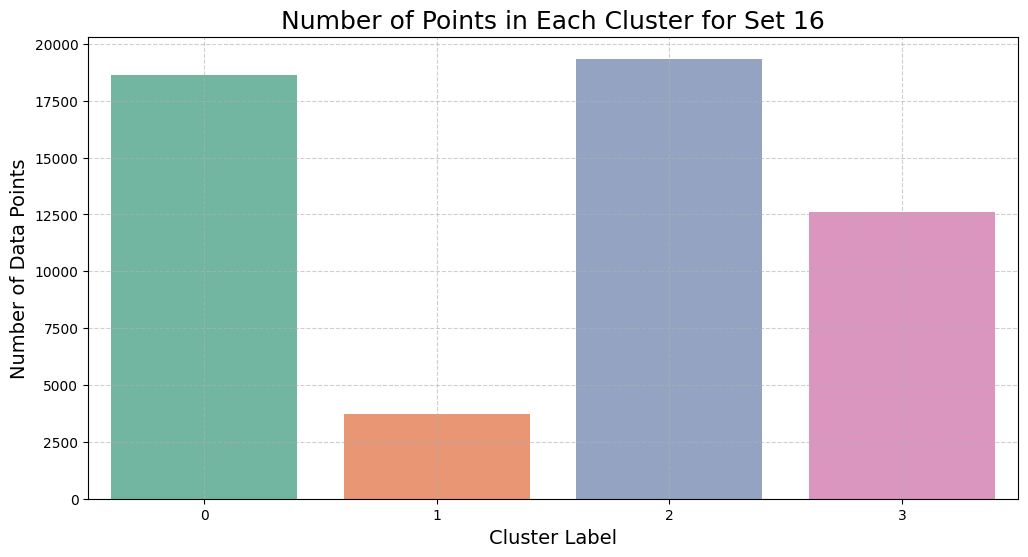

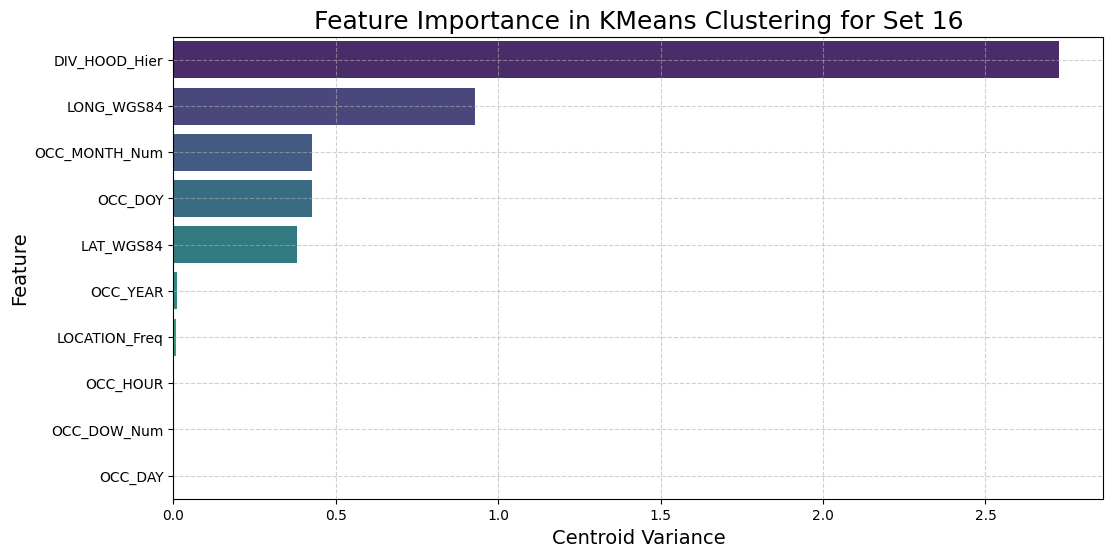

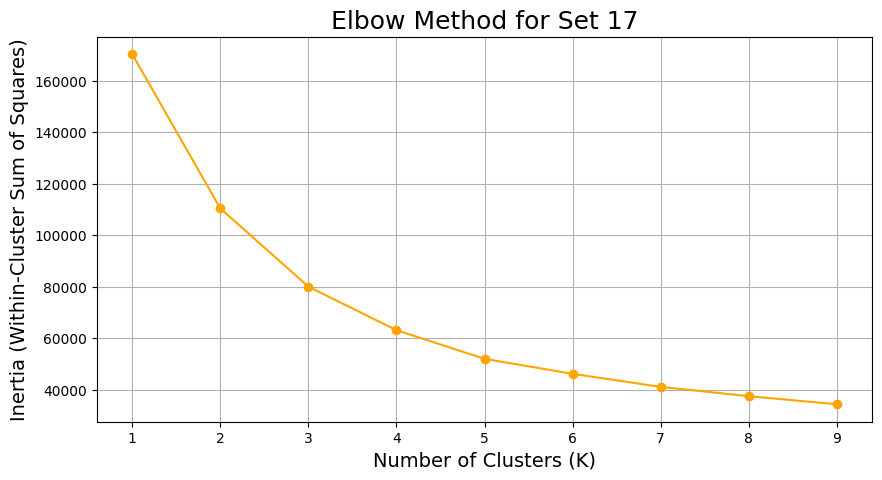

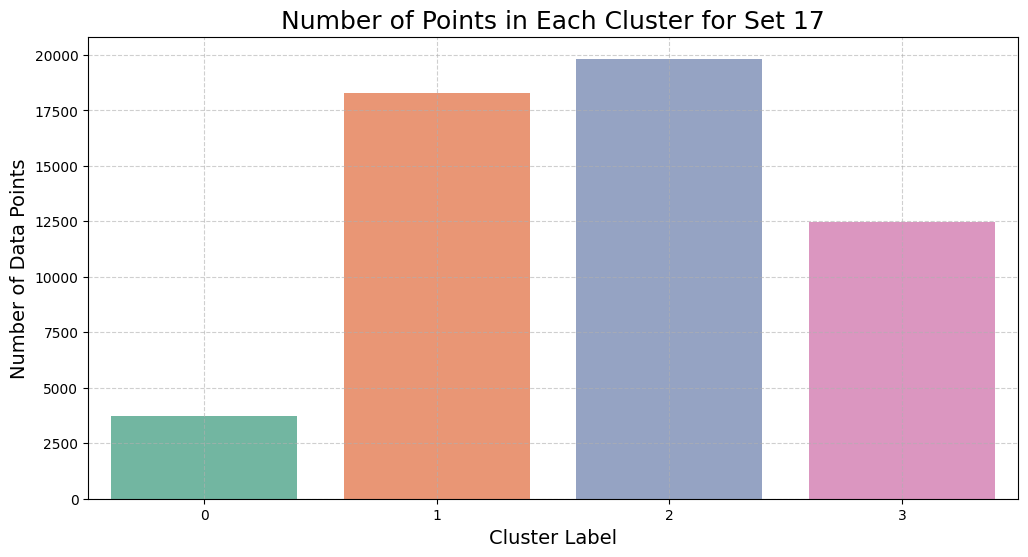

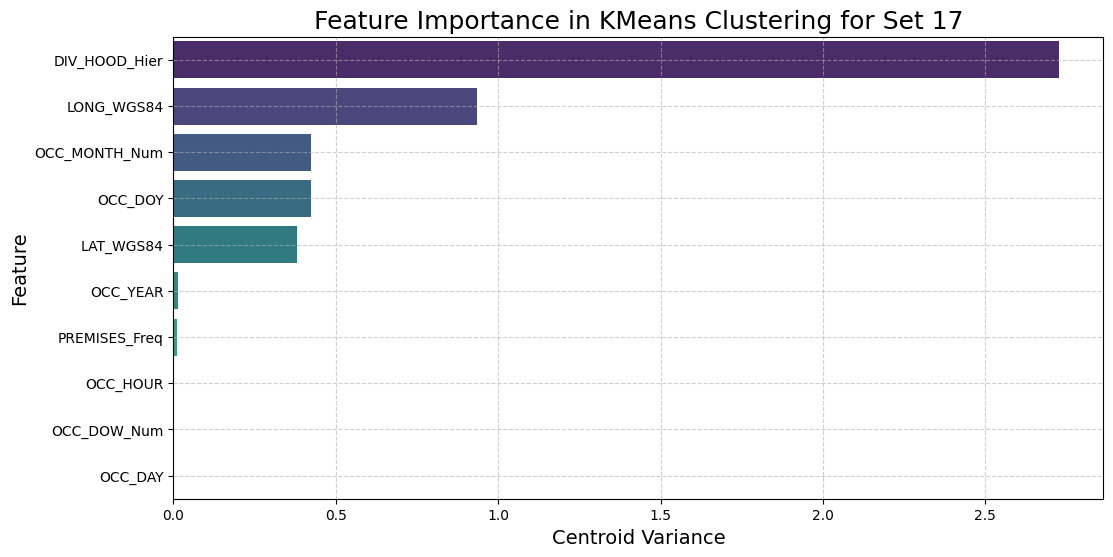

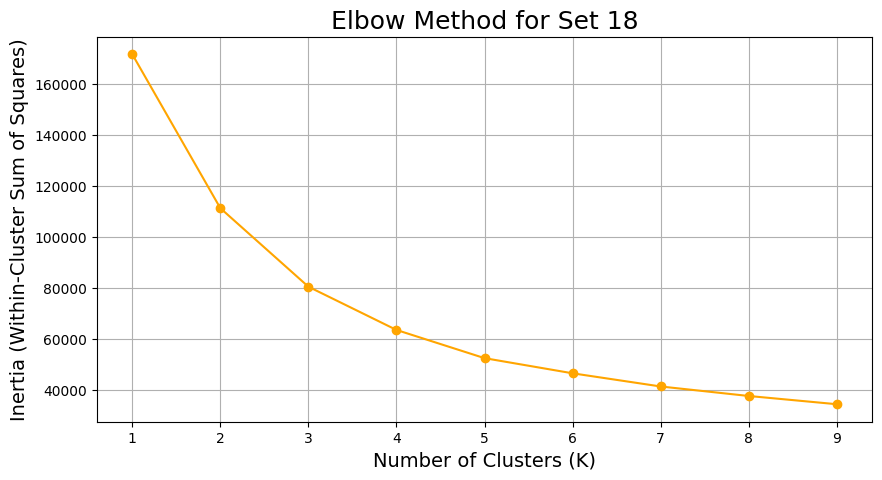

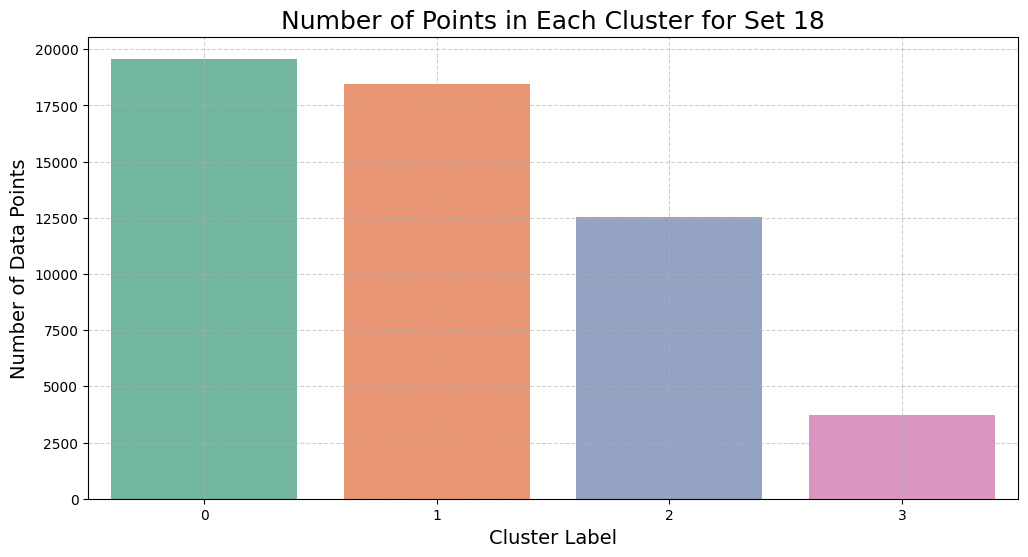

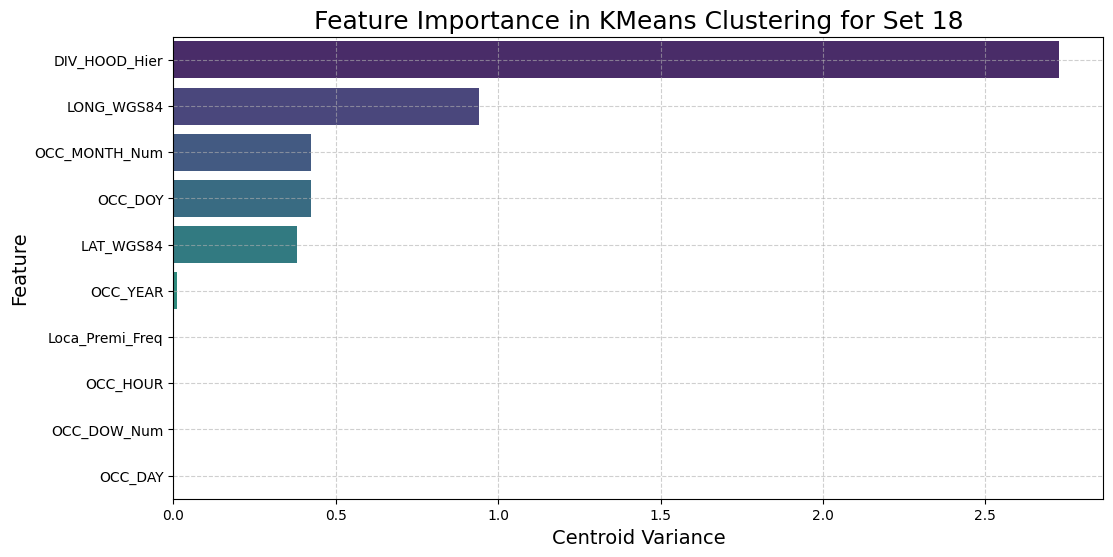

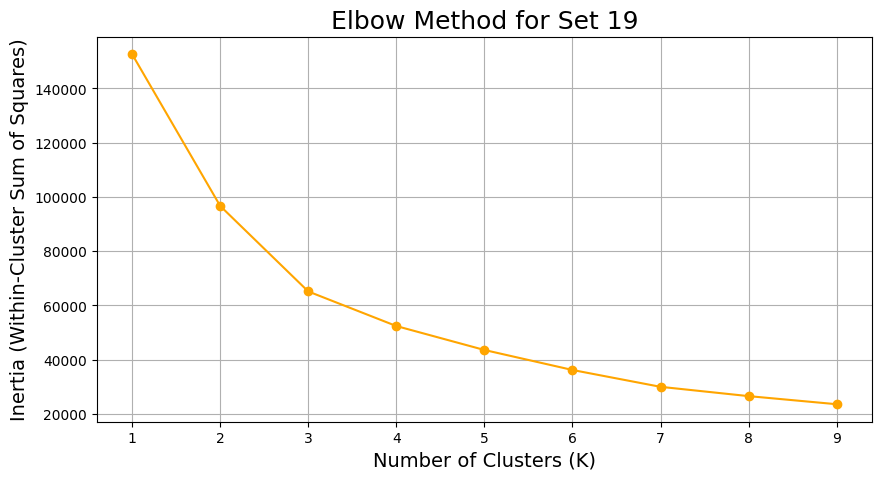

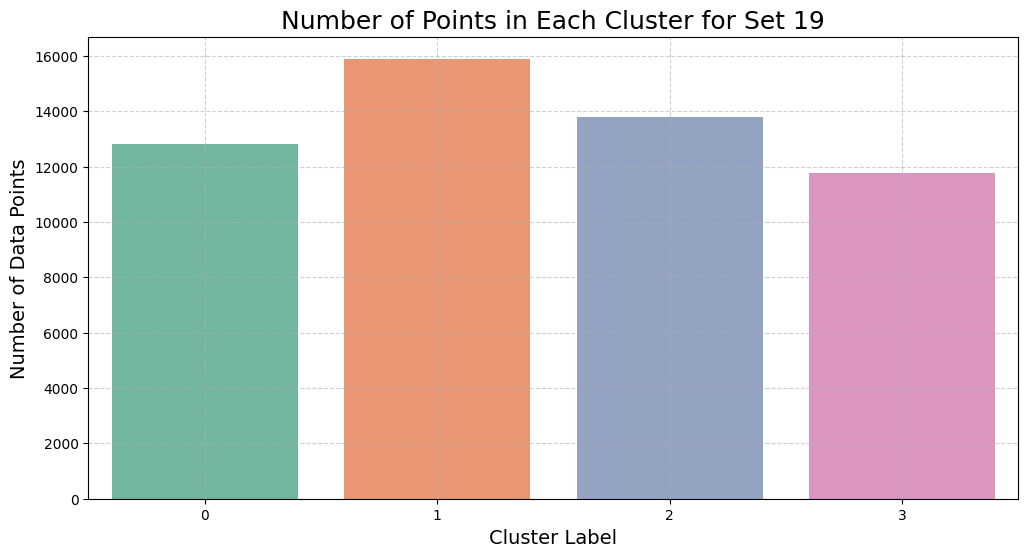

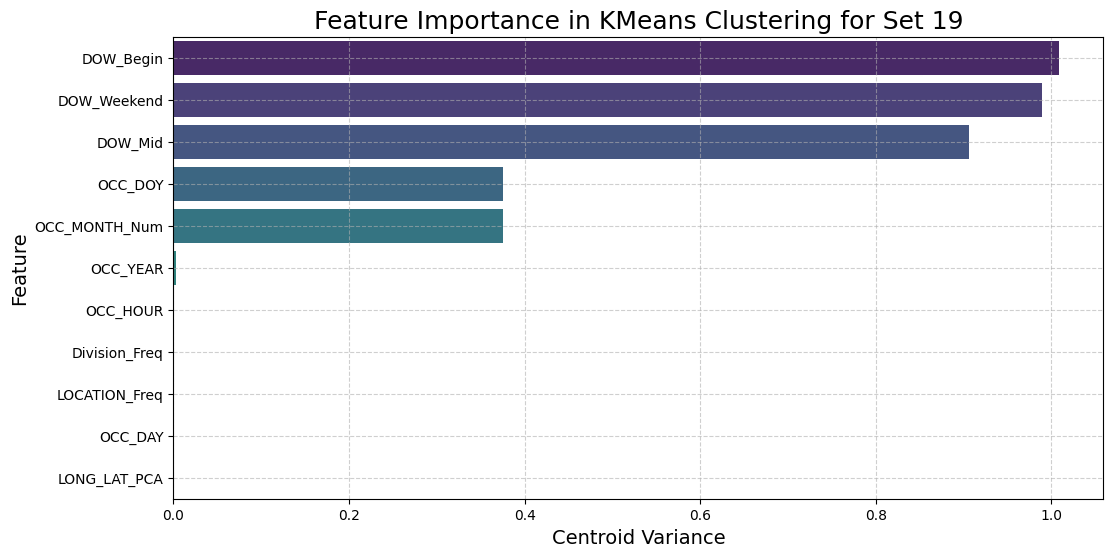

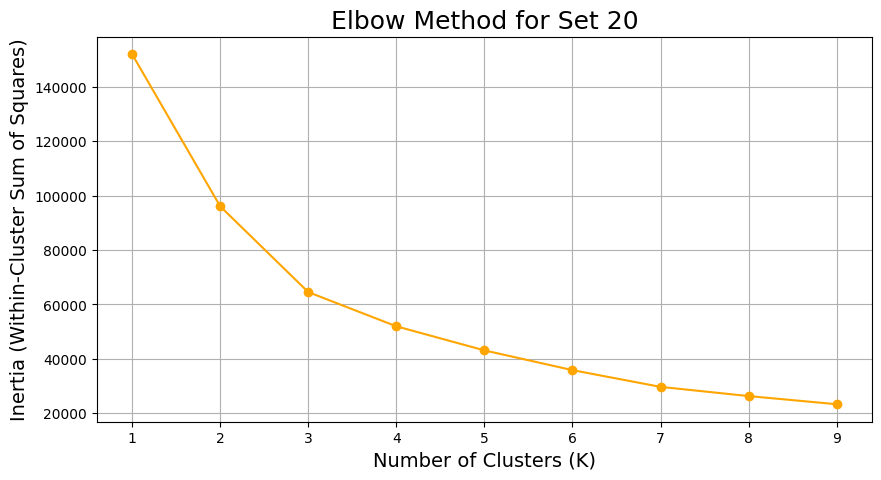

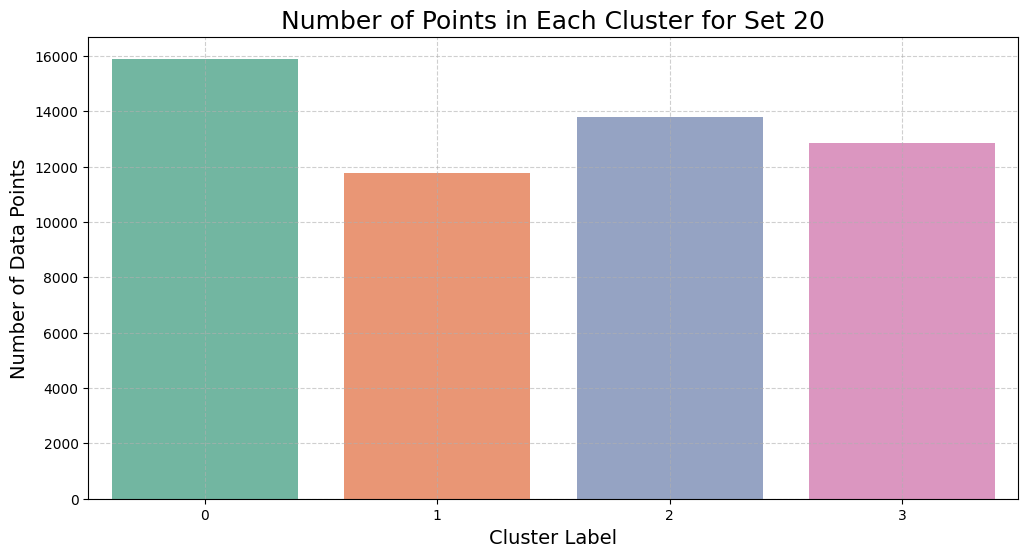

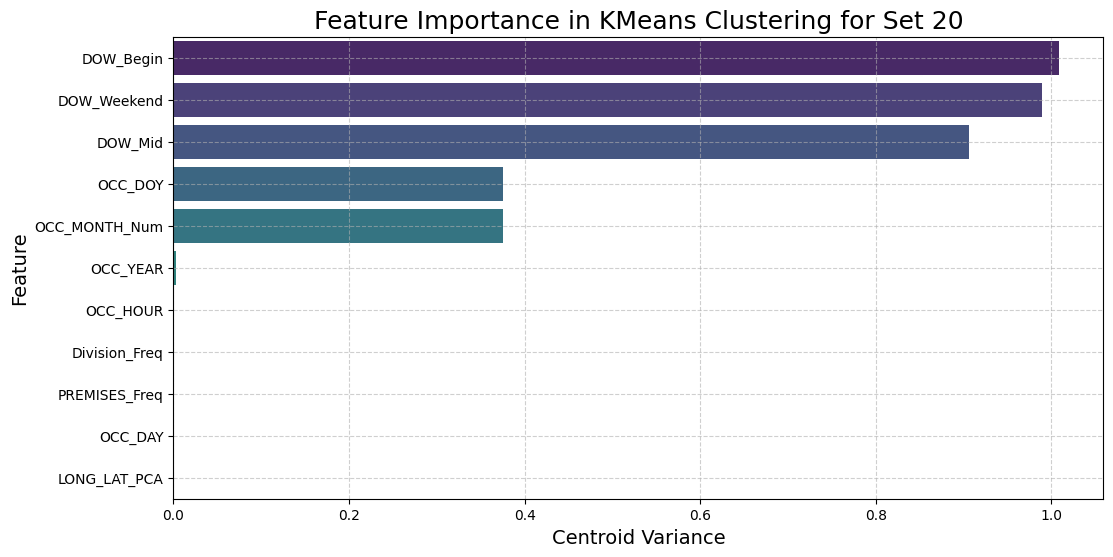

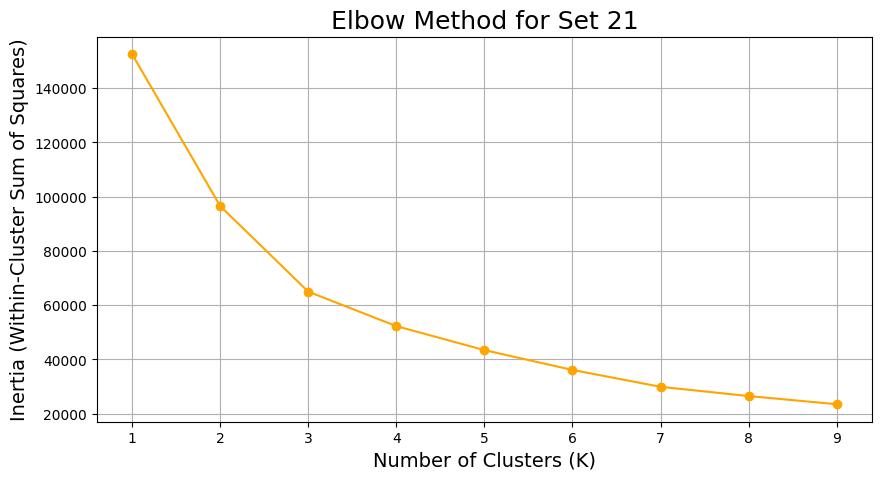

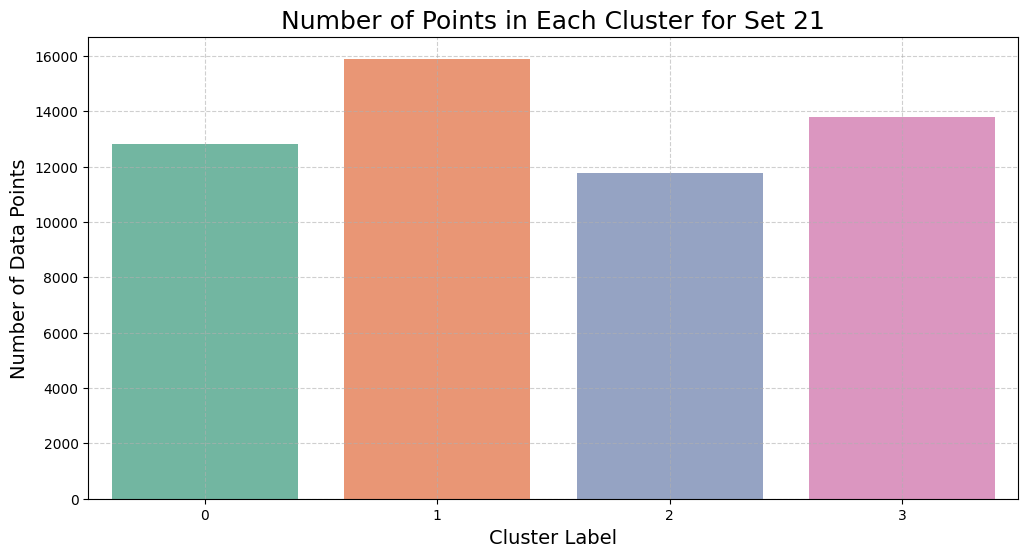

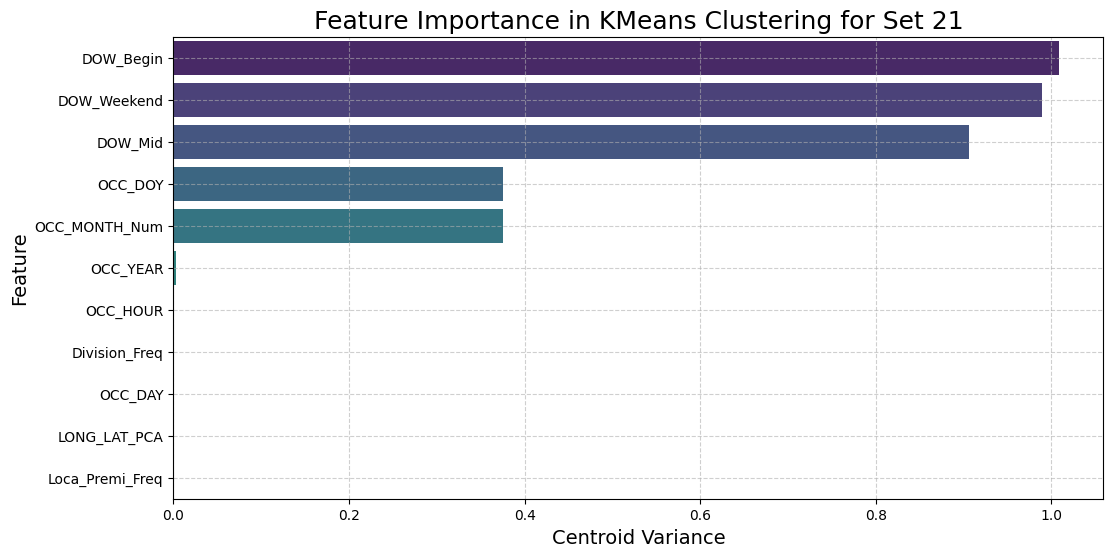

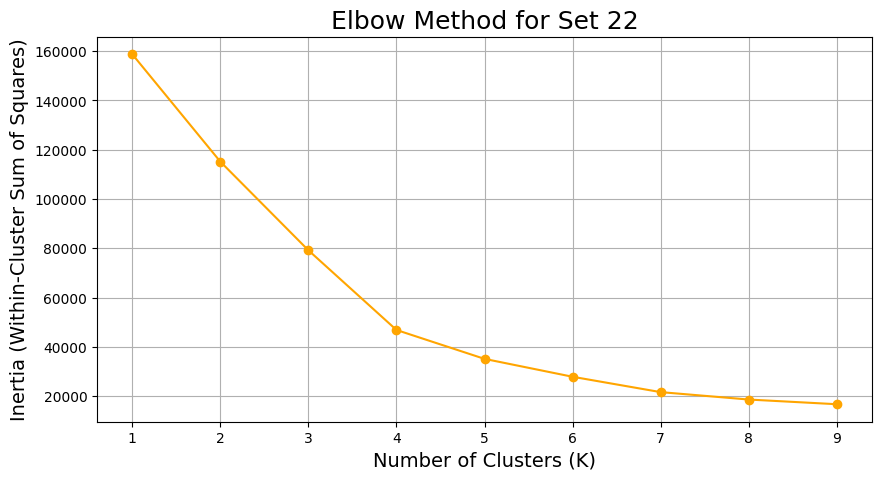

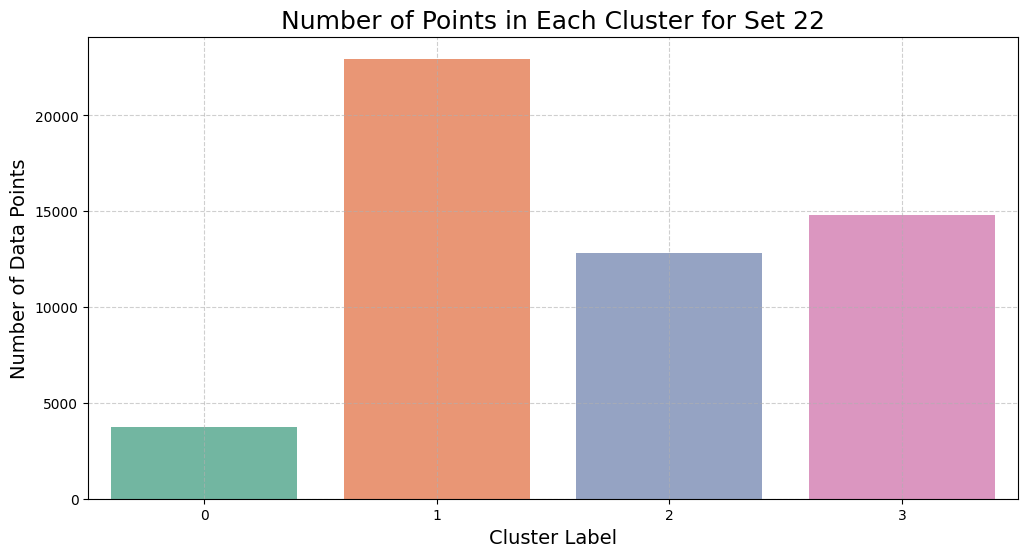

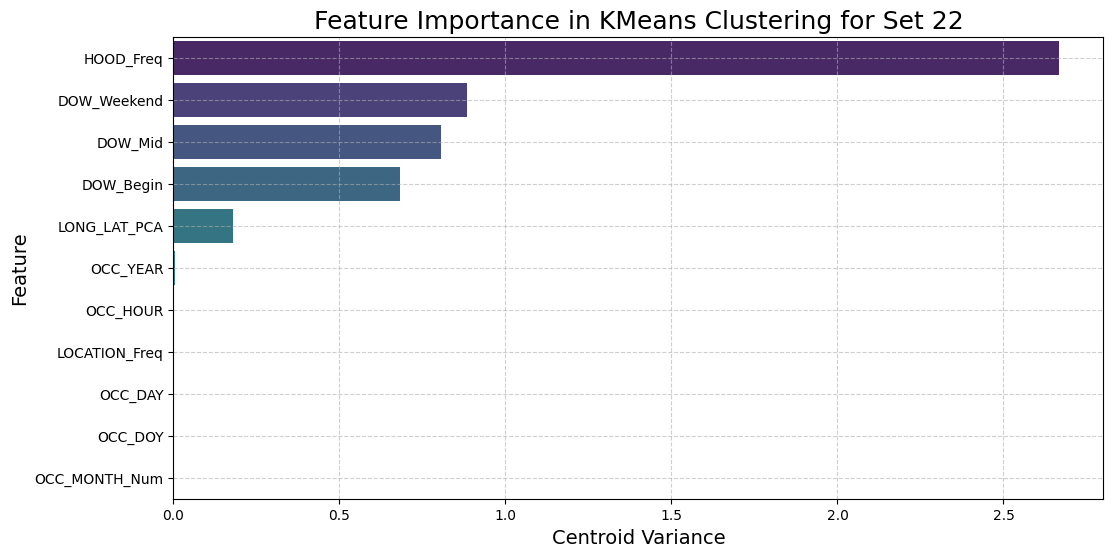

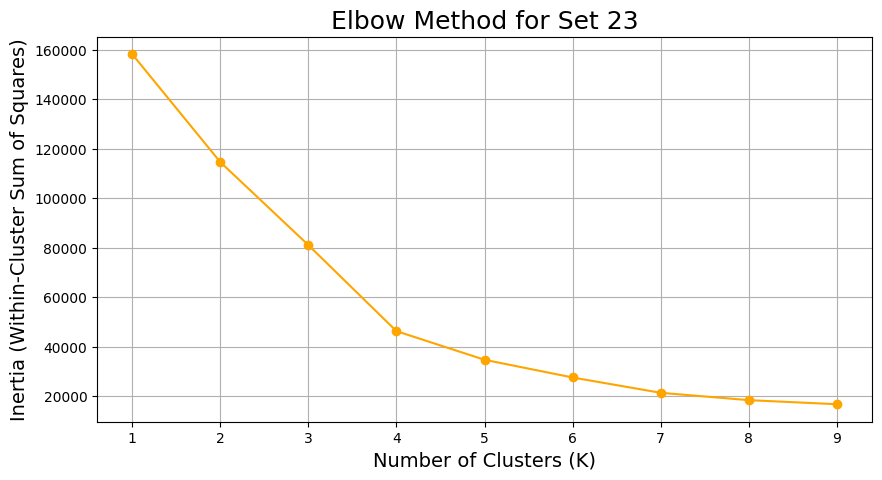

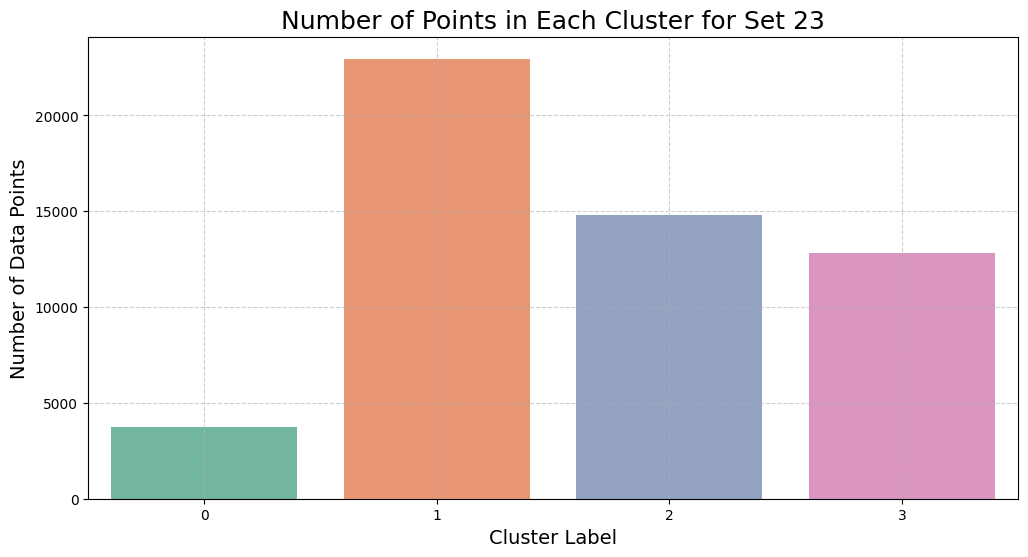

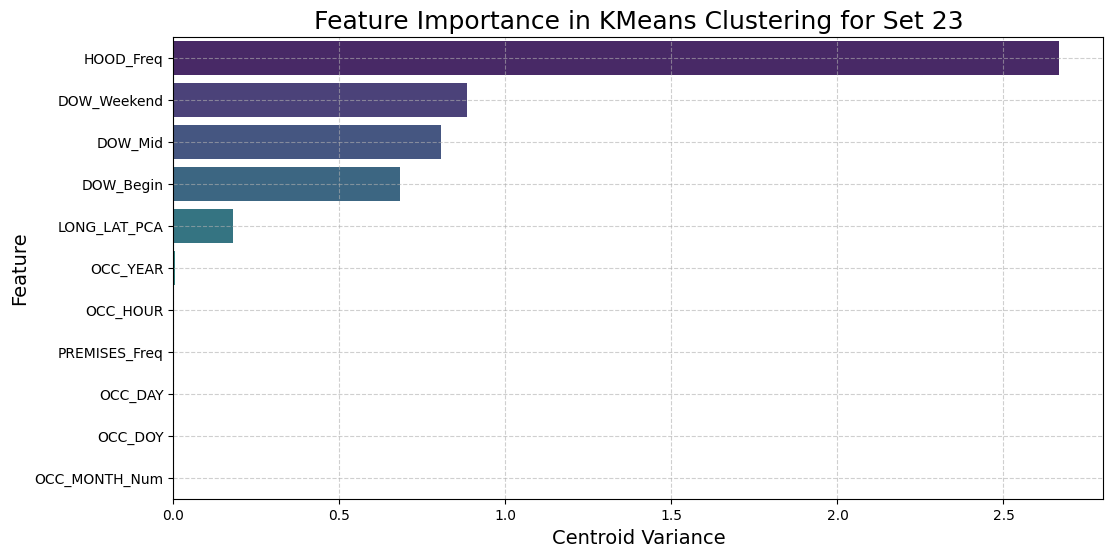

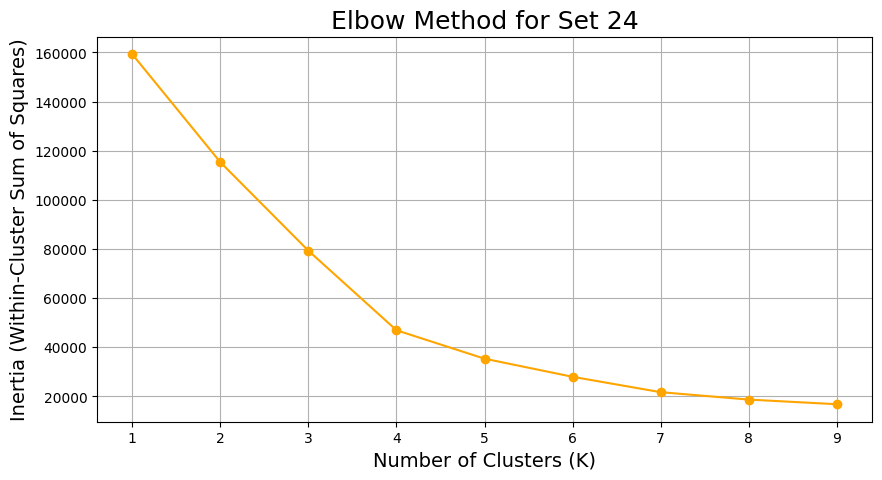

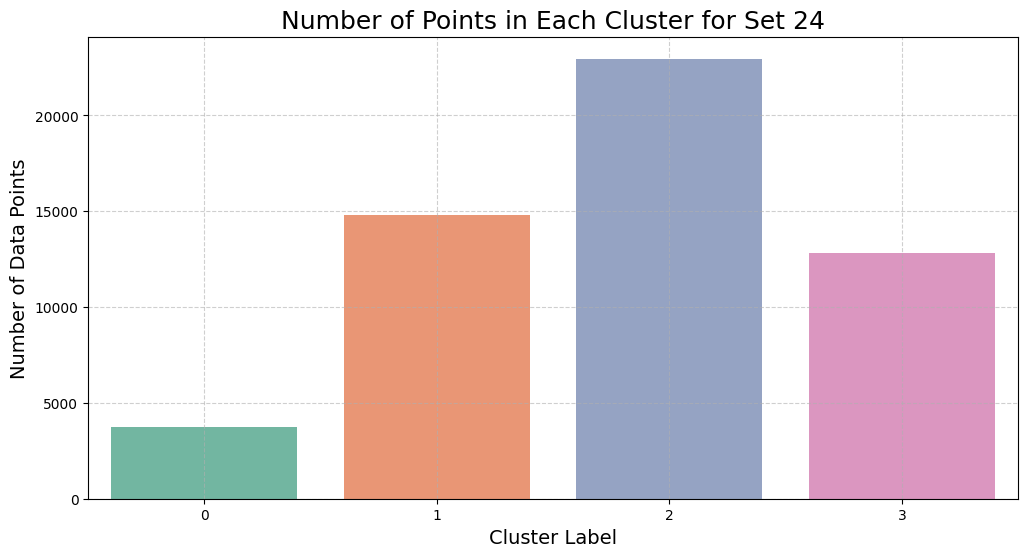

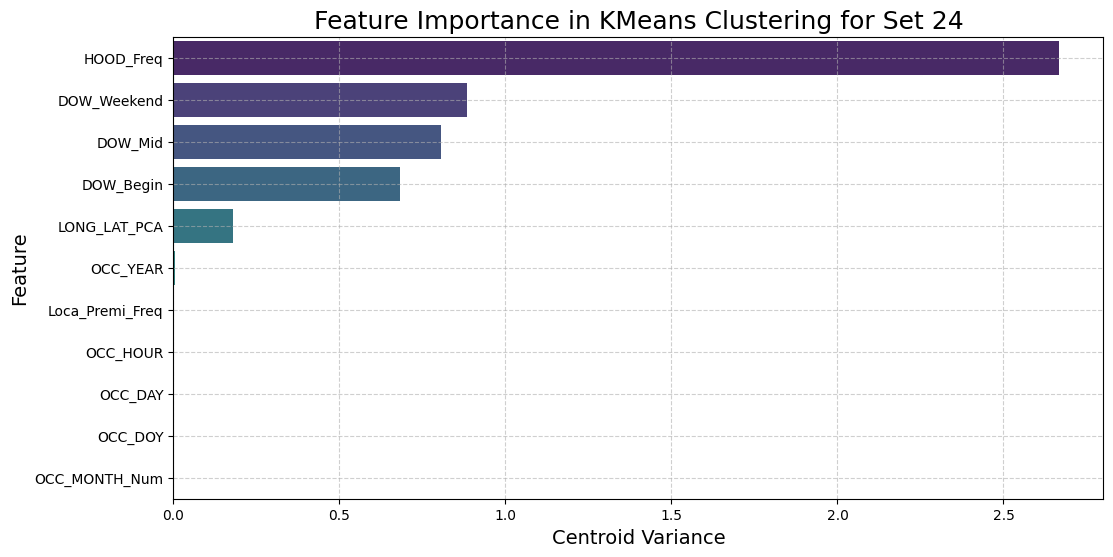

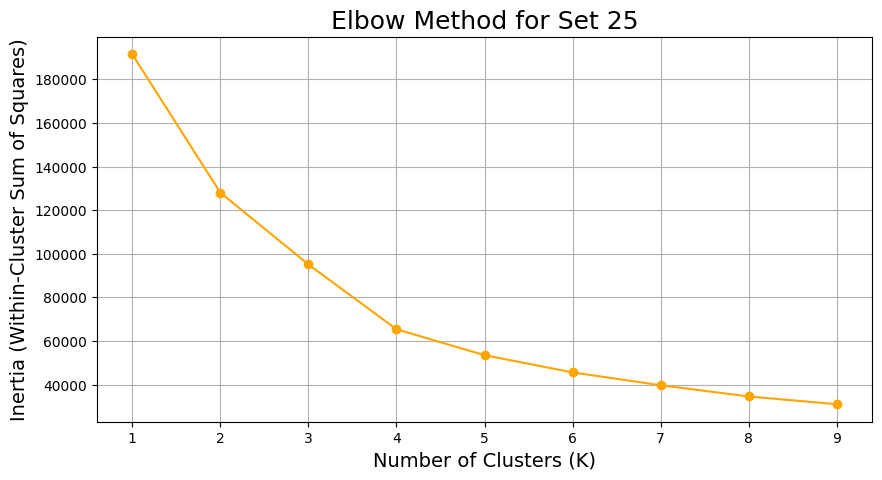

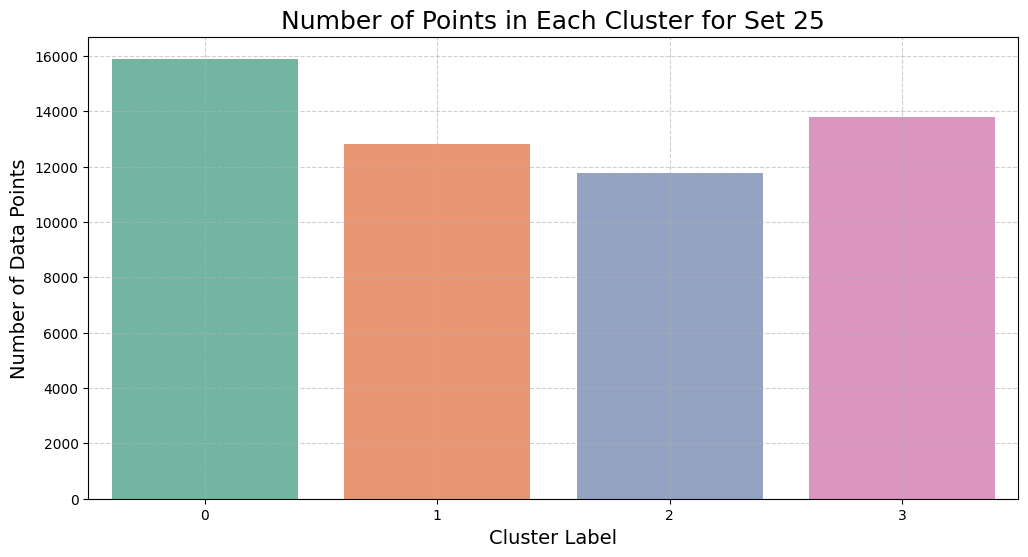

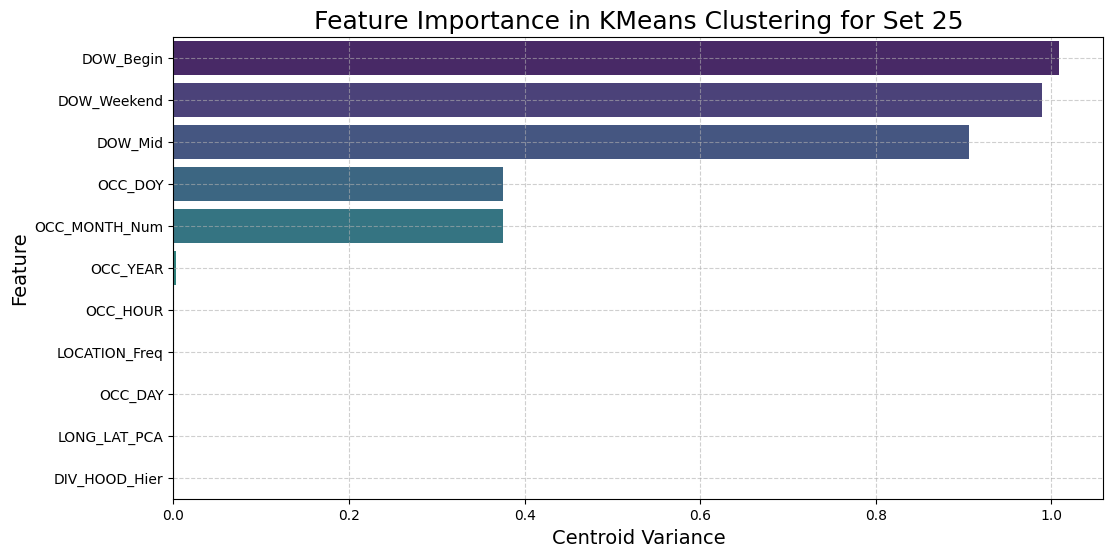

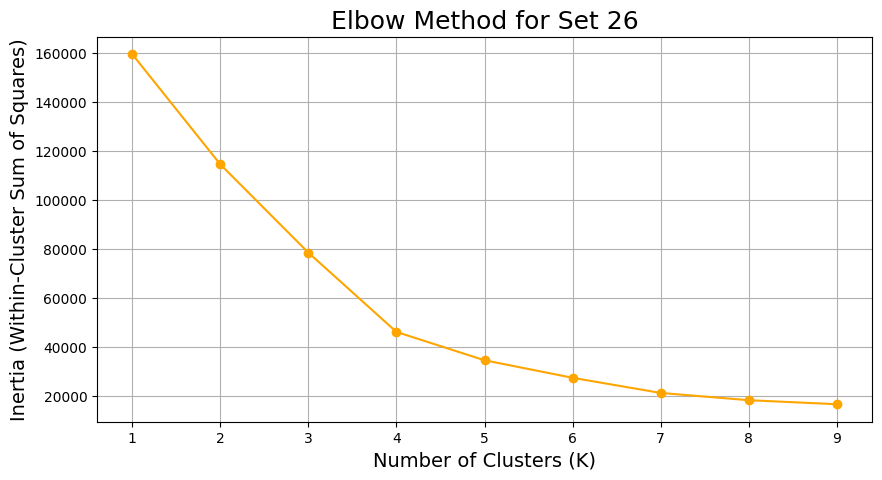

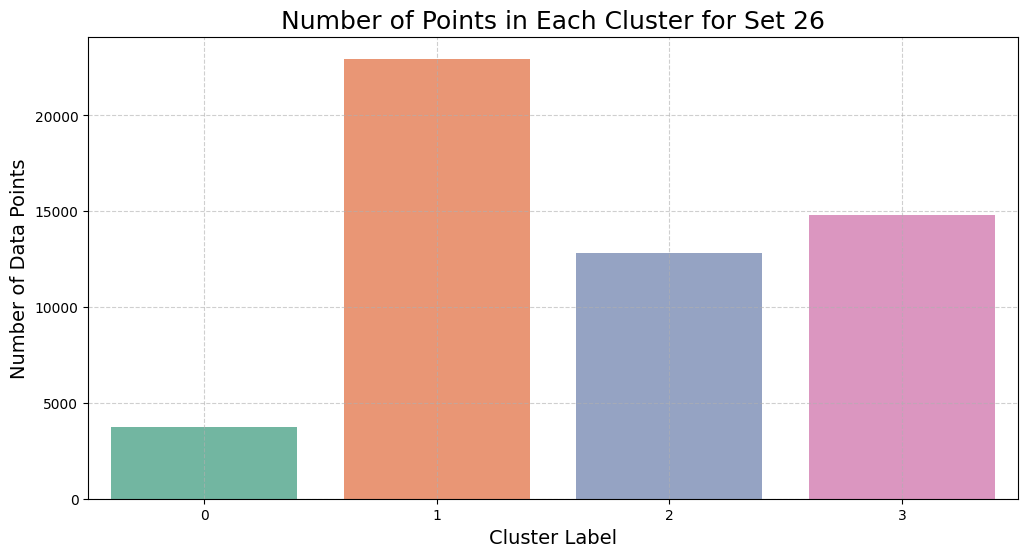

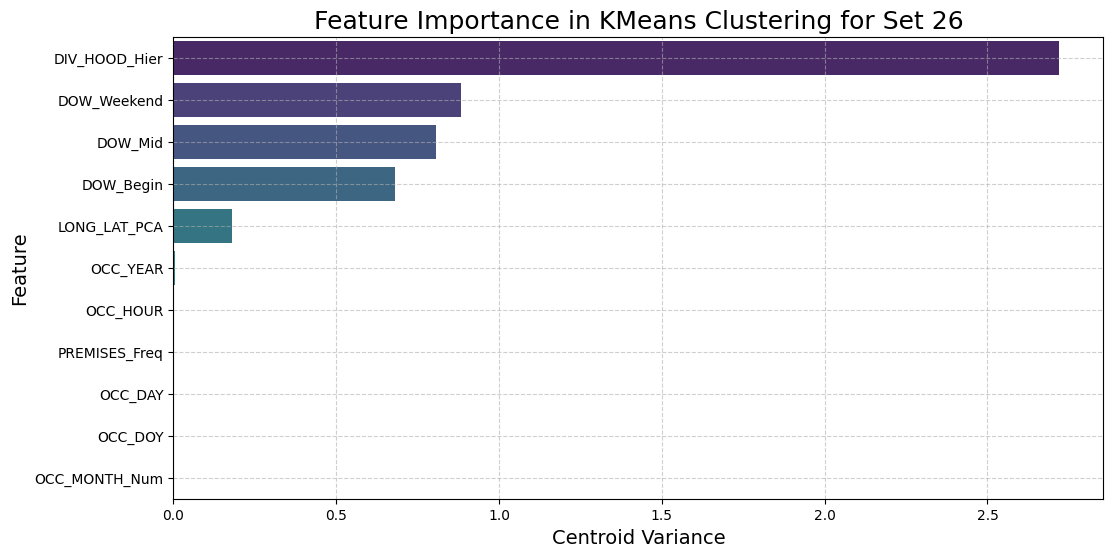

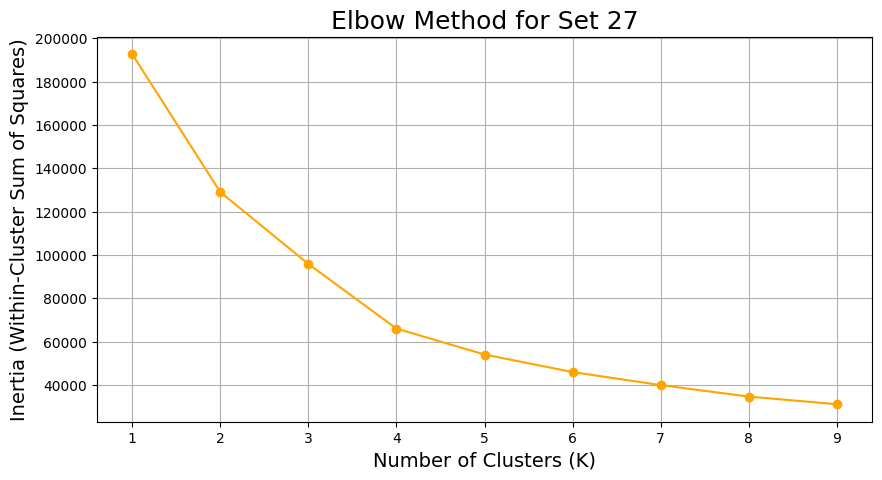

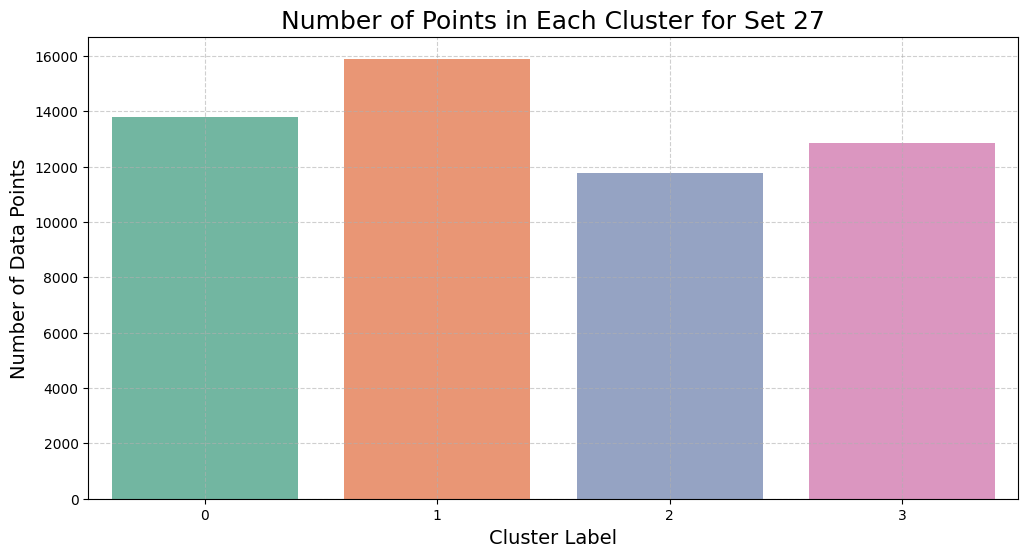

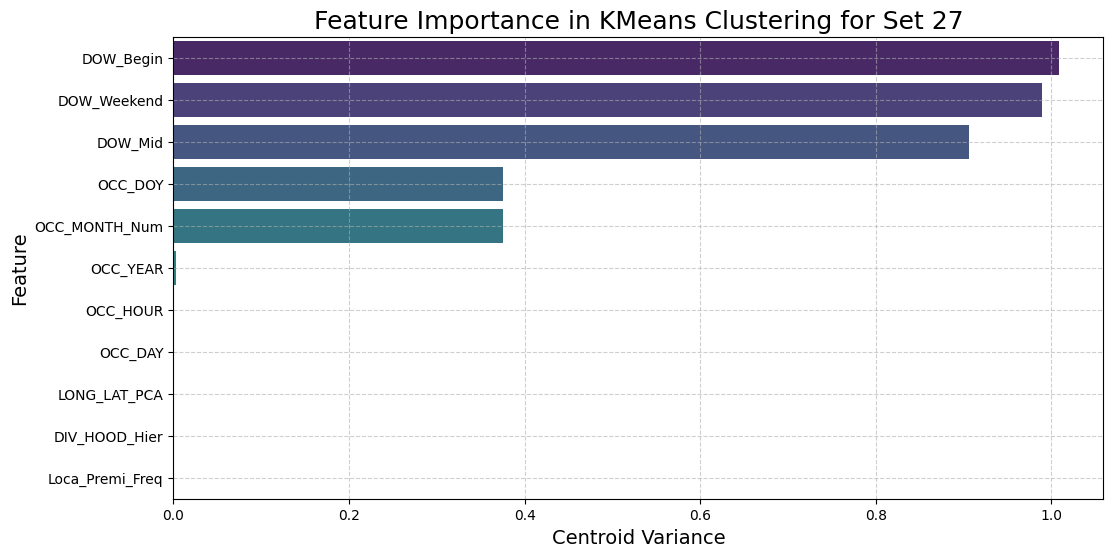

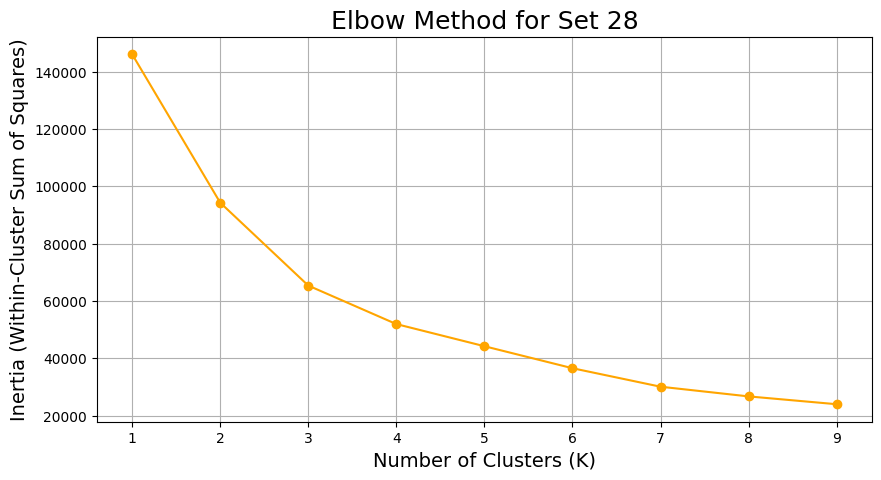

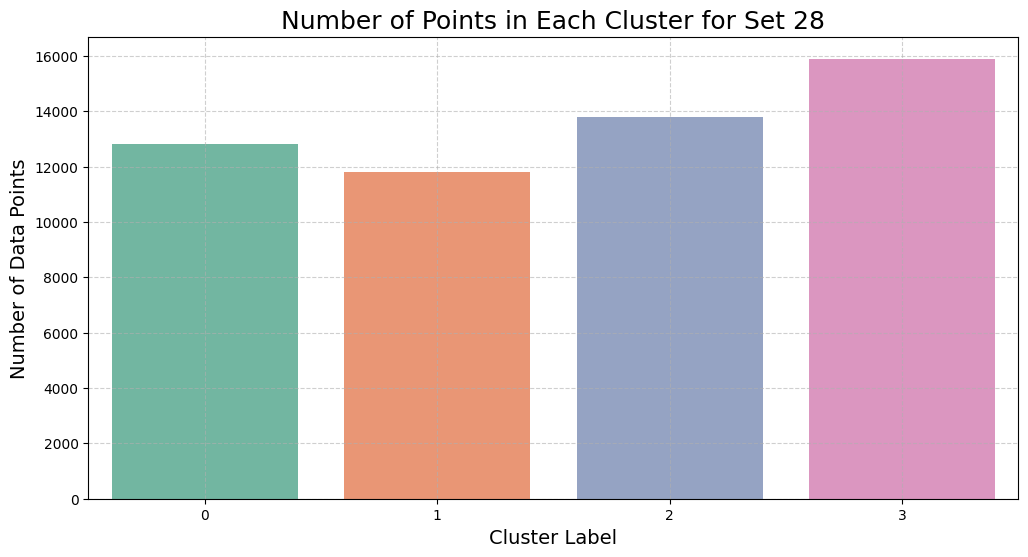

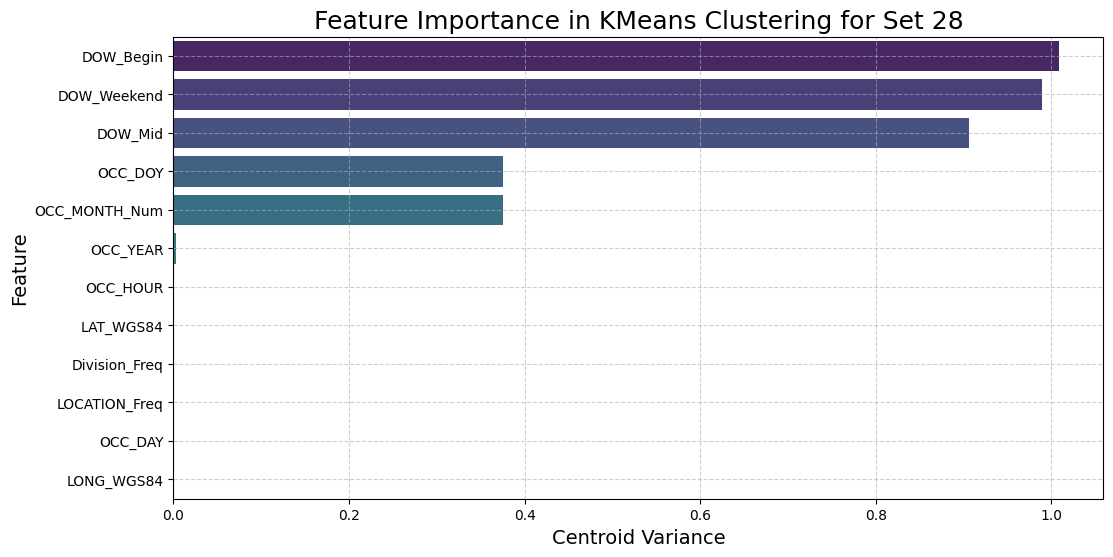

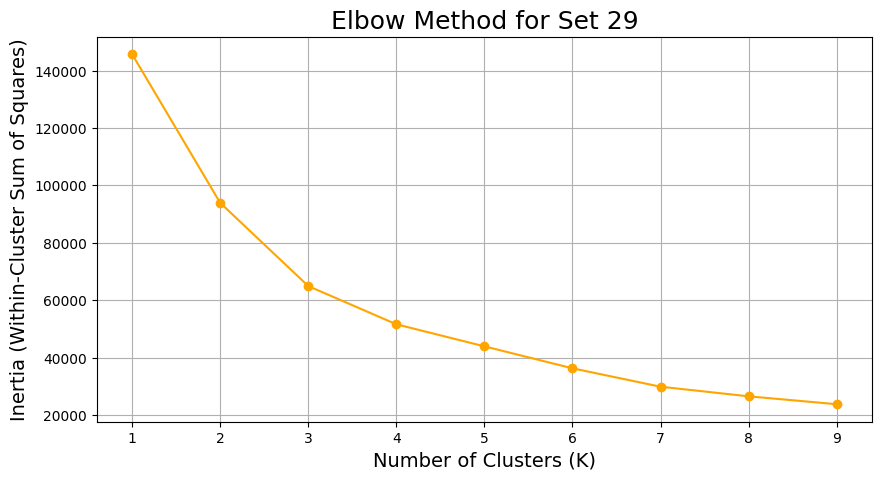

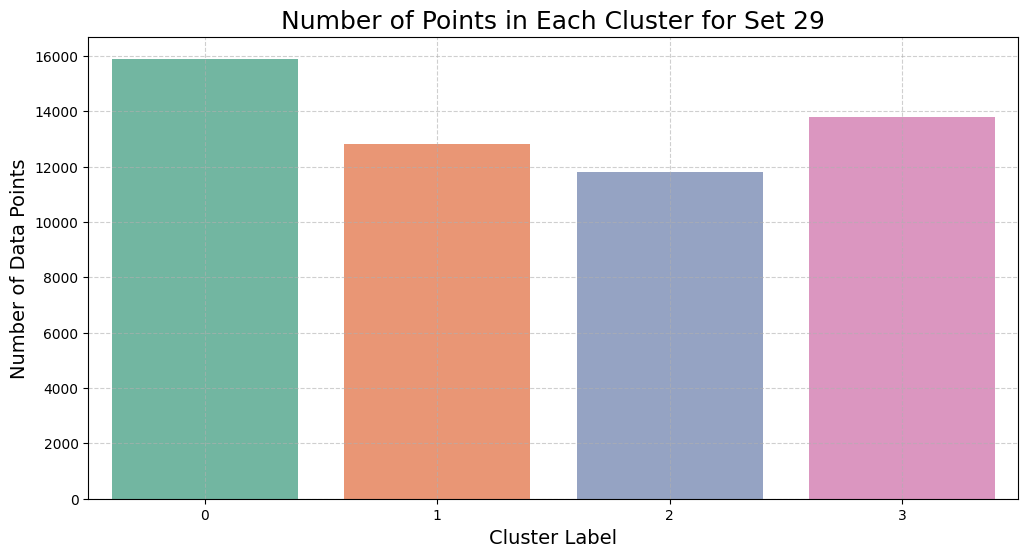

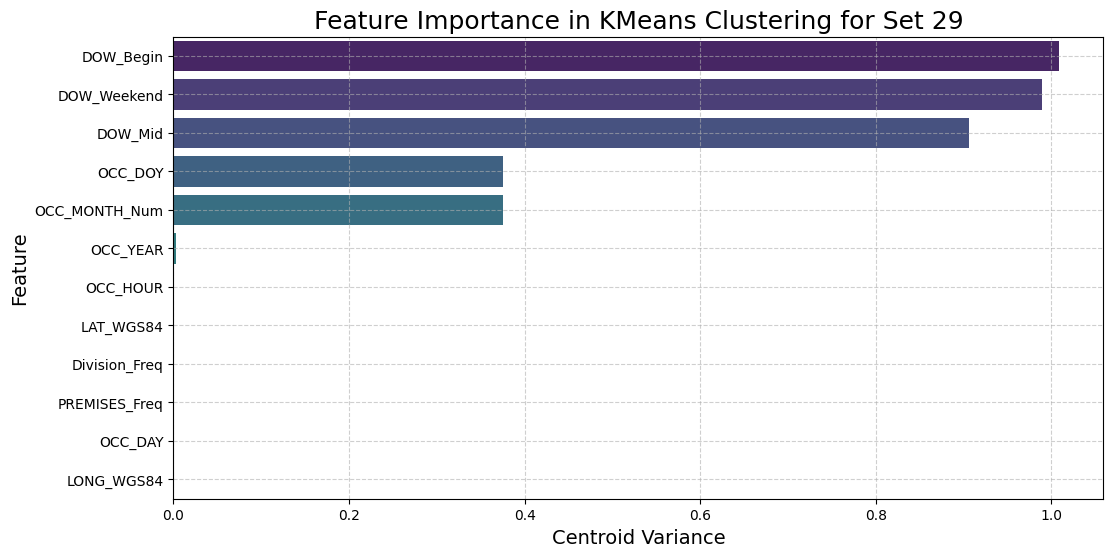

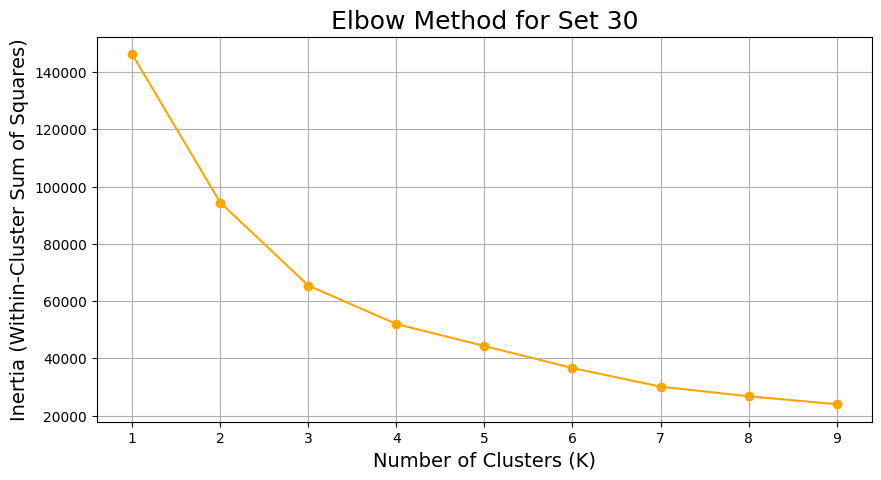

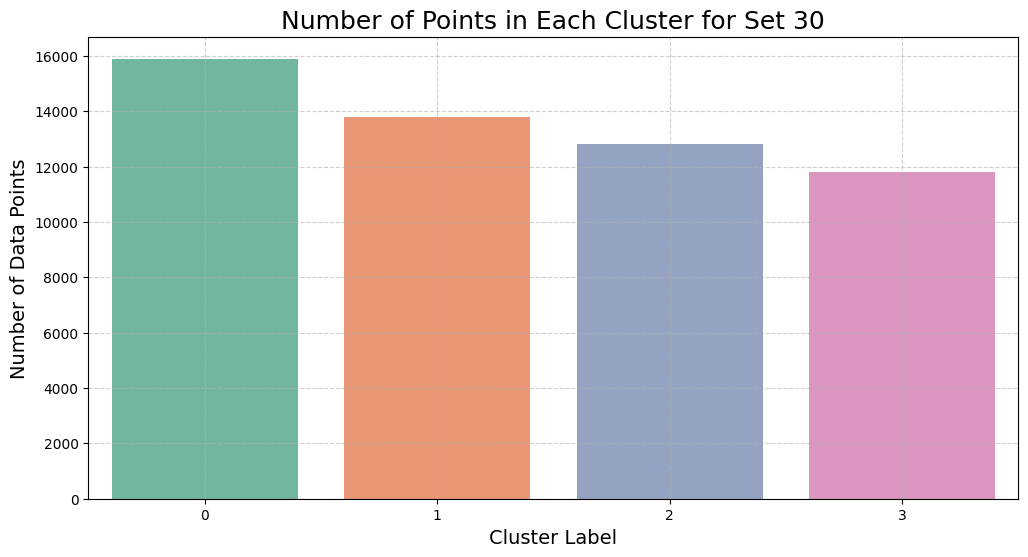

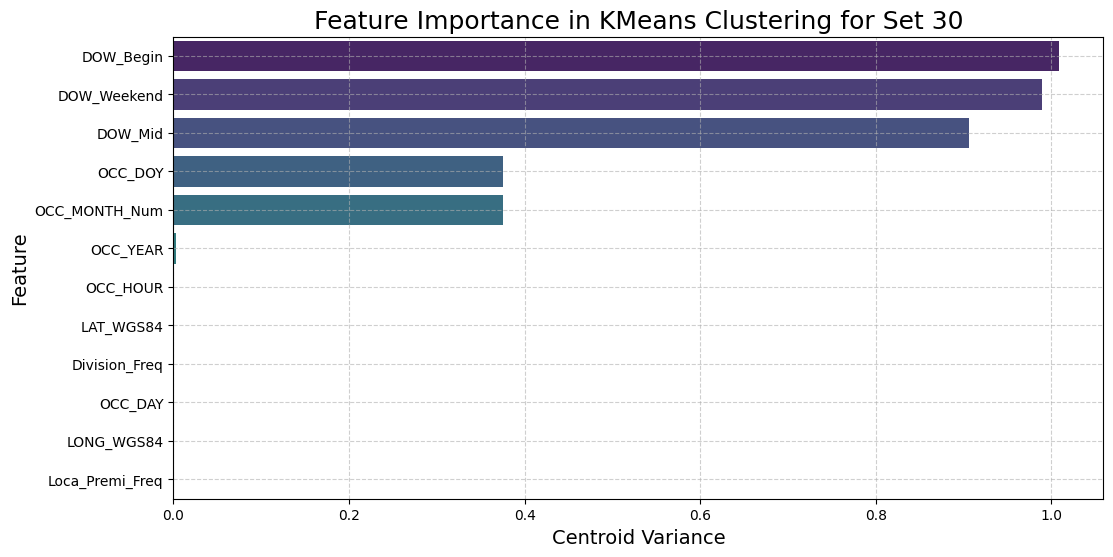

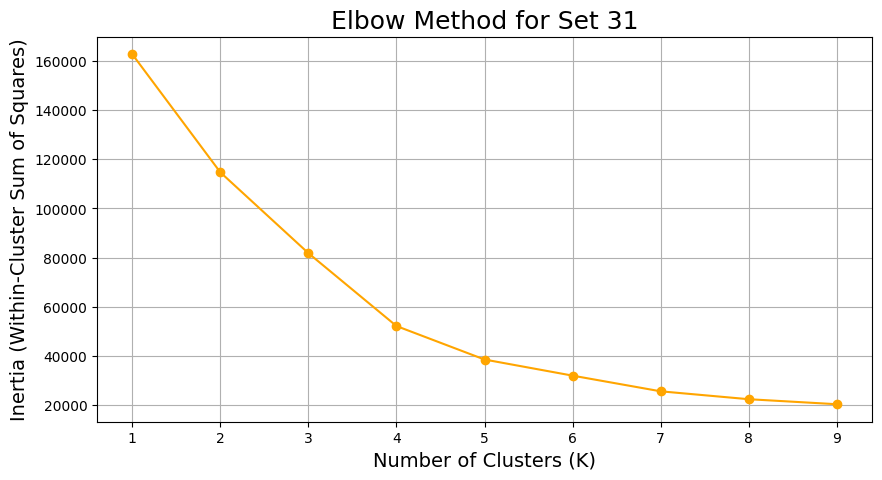

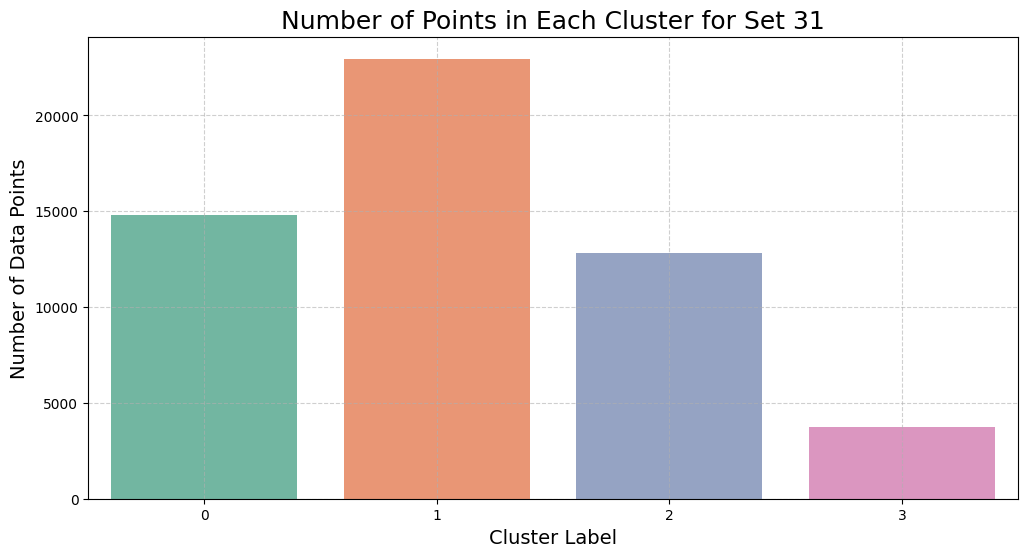

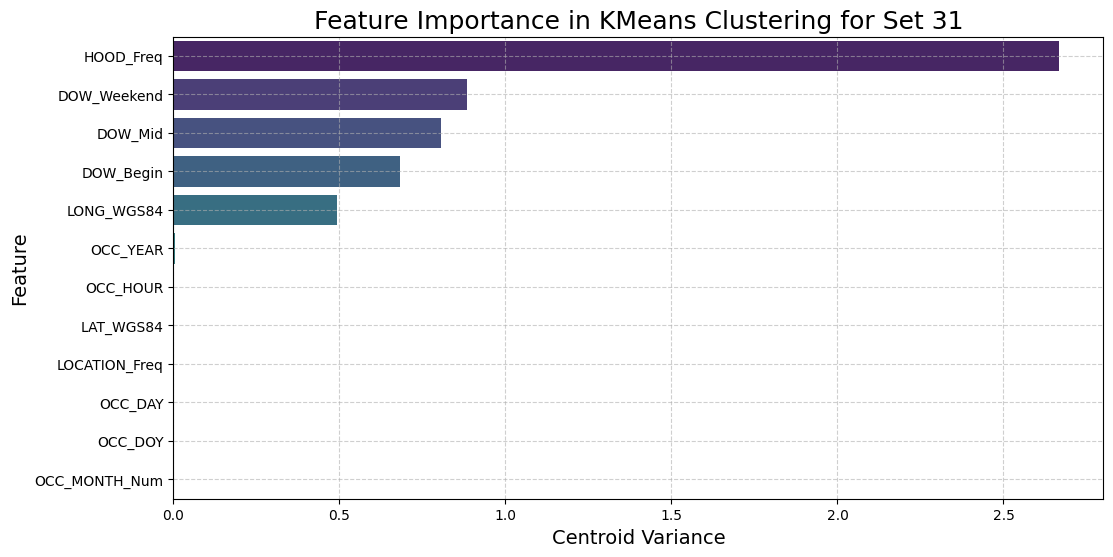

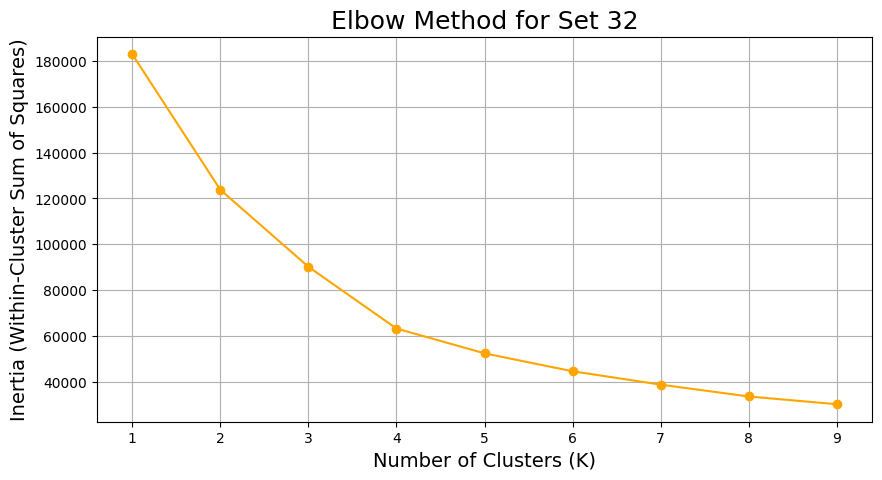

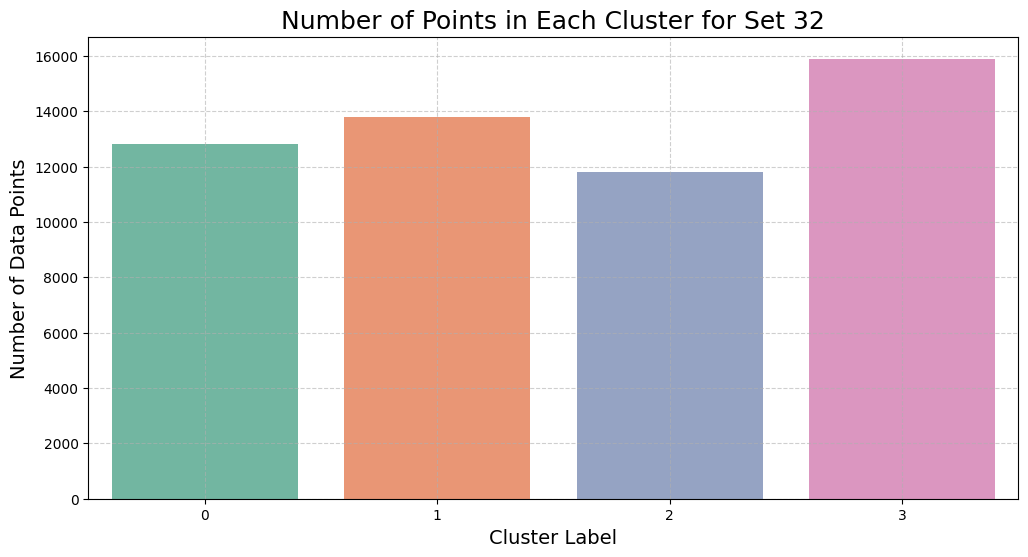

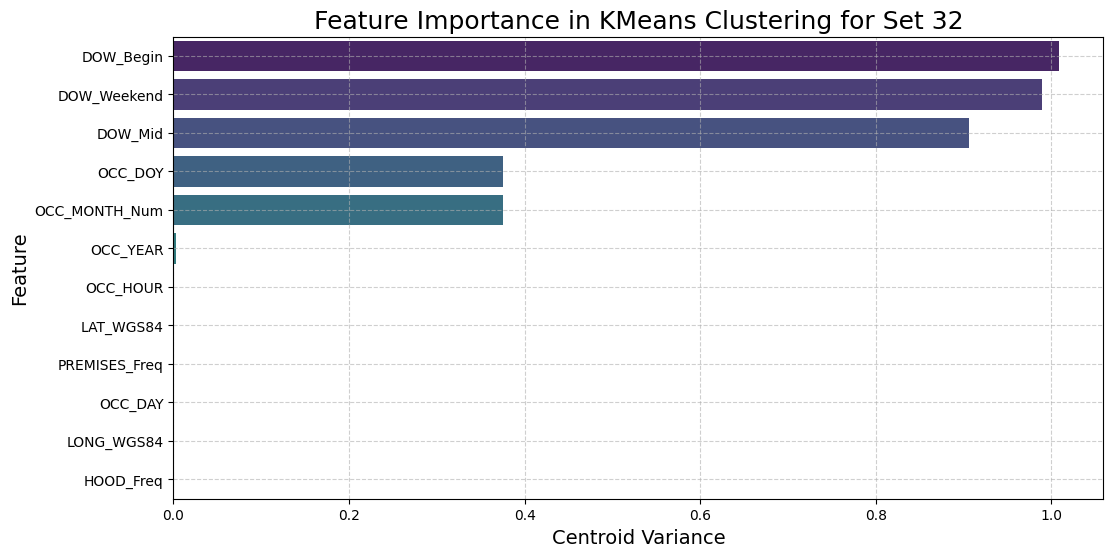

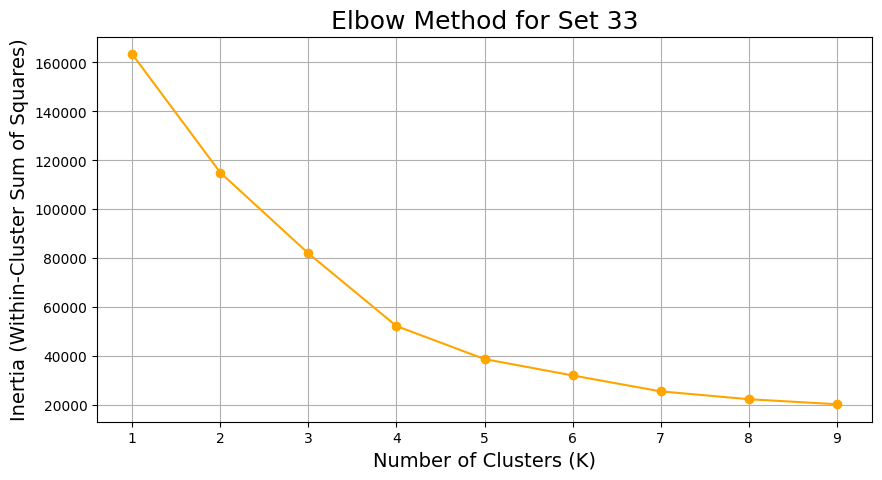

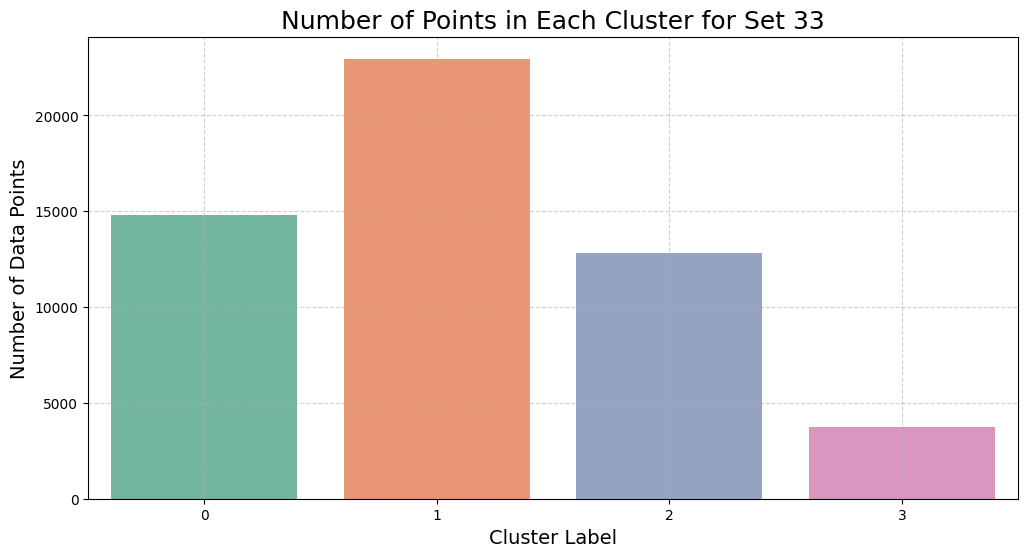

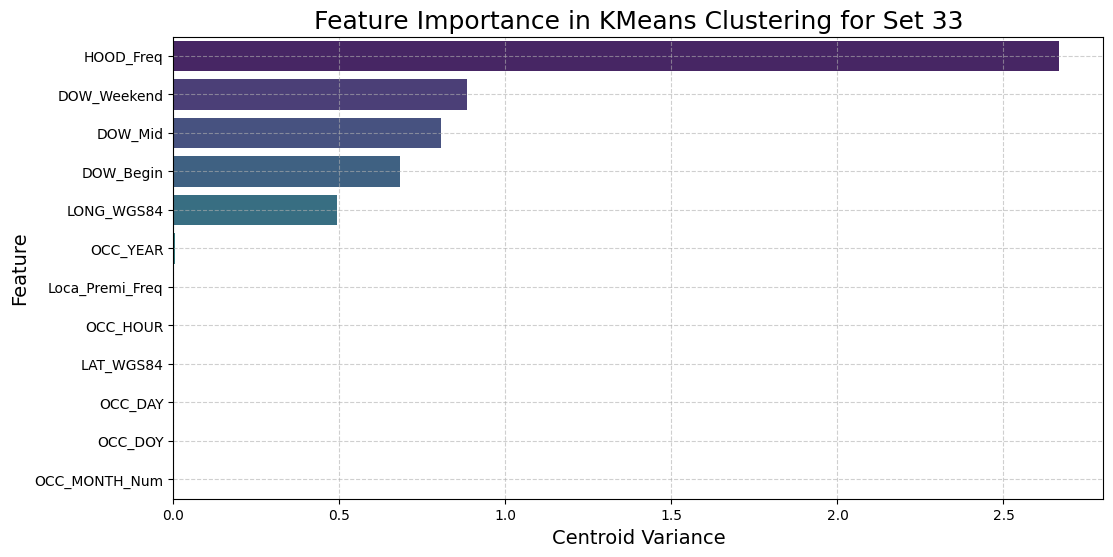

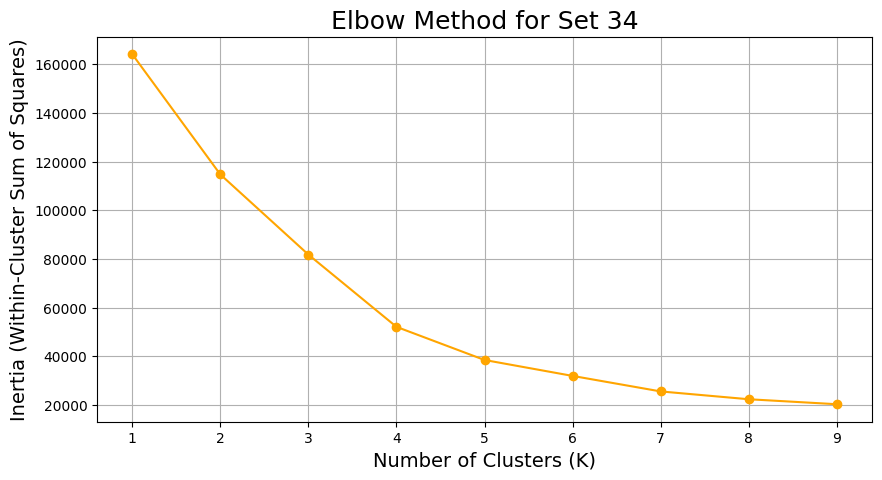

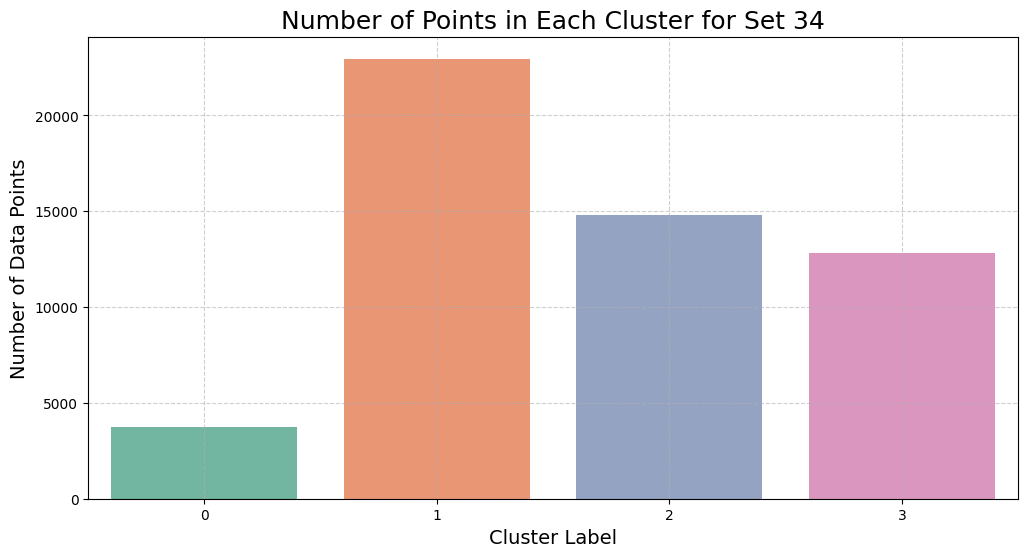

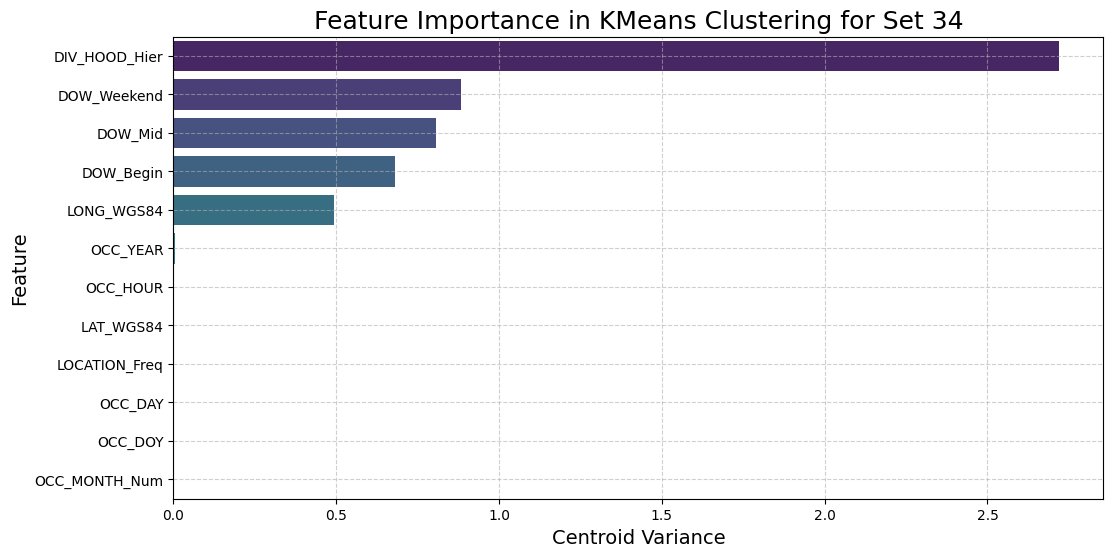

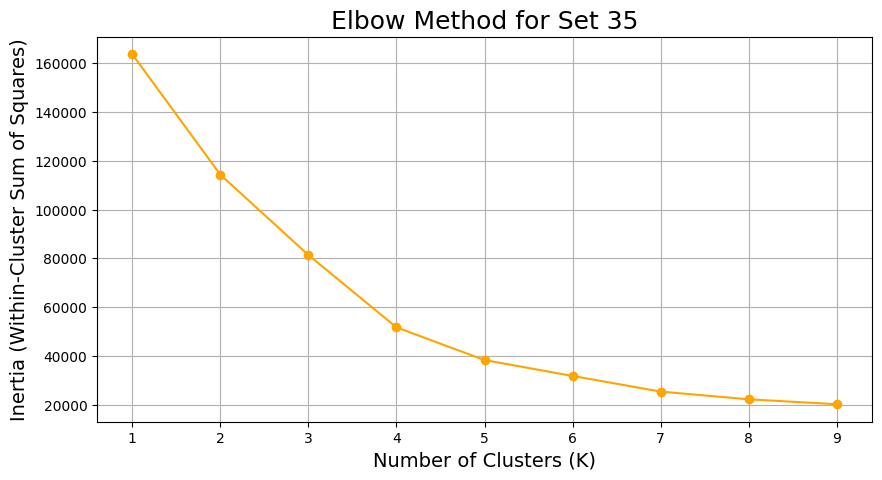

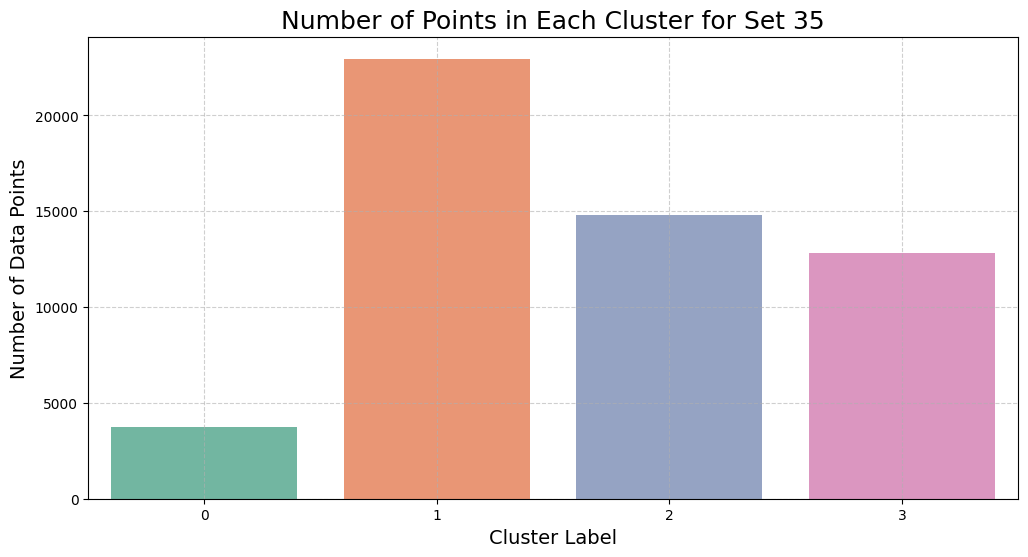

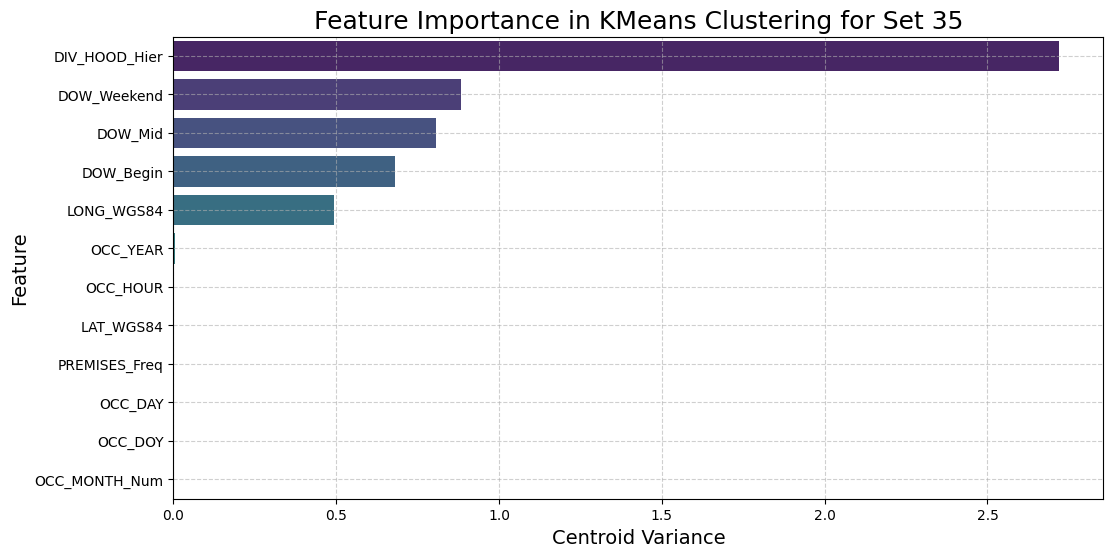

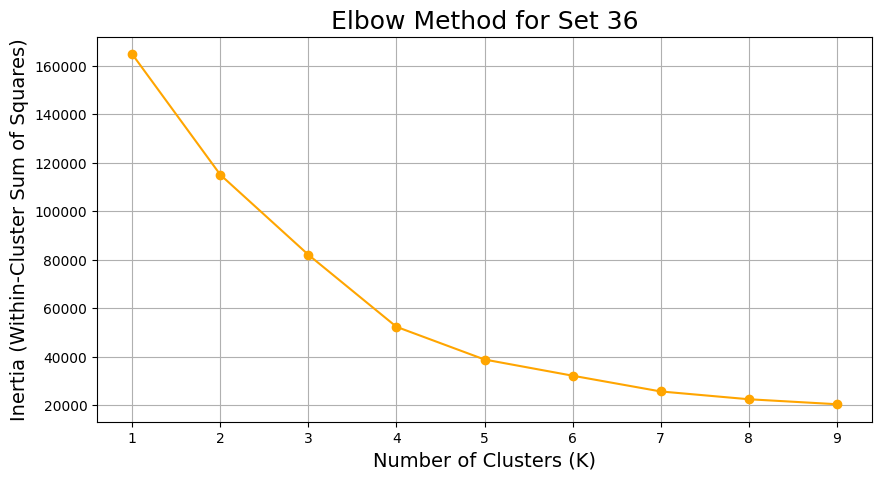

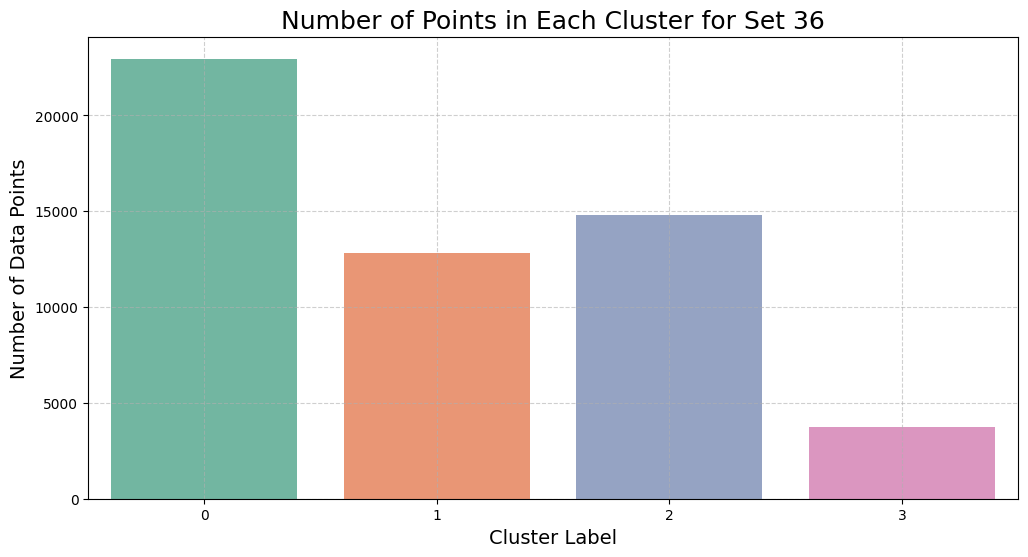

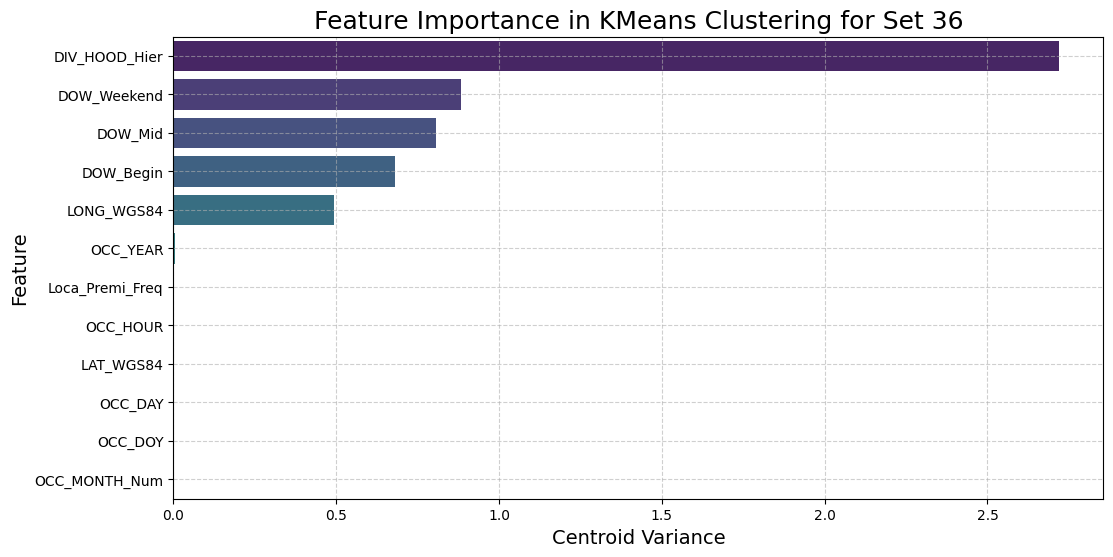

In [ ]:
import warnings, time, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import display, HTML
from google.colab import files

print("\n\n")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ------------------------------------------------------------------------------
# Step 1: Upload and Read Data
# ------------------------------------------------------------------------------
#uploaded = files.upload()  # Upload FE_Encoded_New.csv when prompted
url = "https://raw.githubusercontent.com/mohammadbadi/CrimeAnalytics_Clustering/refs/heads/main/Output_CSV/Final_Data.csv"
df = pd.read_csv("FE_Encoded_New.csv")
display(HTML("<p style='color: green; font-size:16px; font-weight:bold;'>Data loaded successfully from FE_Encoded_New.csv.</p>"))

# ------------------------------------------------------------------------------
# Step 2: Generate All Valid Feature Combinations
# ------------------------------------------------------------------------------
# Base features (always included)
base_features = ["OCC_YEAR", "OCC_DAY", "OCC_DOY", "OCC_MONTH_Num", "OCC_HOUR"]

# Group 1: Either use "OCC_DOW_Num" OR all three: "DOW_Weekend", "DOW_Begin", "DOW_Mid"
group1_options = [
    ["OCC_DOW_Num"],
    ["DOW_Weekend", "DOW_Begin", "DOW_Mid"]
]

# Group 2: Either use "LONG_LAT_PCA" OR both "LONG_WGS84" and "LAT_WGS84"
group2_options = [
    ["LONG_LAT_PCA"],
    ["LONG_WGS84", "LAT_WGS84"]
]

# Group 3: Exactly one from "Division_Freq", "HOOD_Freq", "DIV_HOOD_Hier"
group3_options = [
    ["Division_Freq"],
    ["HOOD_Freq"],
    ["DIV_HOOD_Hier"]
]

# Group 4: Exactly one from "LOCATION_Freq", "PREMISES_Freq", "Loca_Premi_Freq"
group4_options = [
    ["LOCATION_Freq"],
    ["PREMISES_Freq"],
    ["Loca_Premi_Freq"]
]

# Generate all combinations: total sets = 2 * 2 * 3 * 3 = 36 sets
all_combos = []
for g1 in group1_options:
    for g2 in group2_options:
        for g3 in group3_options:
            for g4 in group4_options:
                combo = base_features + g1 + g2 + g3 + g4
                all_combos.append(combo)

# Print all generated sets
print("Total Feature Set Combinations Produced:", len(all_combos))
for idx, combo in enumerate(all_combos, start=1):
    print(f"Set {idx}: {combo}")

# ------------------------------------------------------------------------------
# Step 3: Clustering Analysis for Each Feature Set
# ------------------------------------------------------------------------------
results = []  # To store summary metrics of each set

for set_index, features in enumerate(all_combos, start=1):
    display(HTML(f"<h3 style='color: navy;'>Processing Feature Set {set_index}: {features}</h3>"))

    # Subset data and drop rows with missing values in the selected features
    data_subset = df[features].dropna().copy()

    # Build pipeline: Standardize + KMeans (fixed n_clusters=4)
    scaler = StandardScaler()
    preprocessor = ColumnTransformer([('num', scaler, features)])
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=4, random_state=42, n_init=10))
    ])
    pipeline.fit(data_subset)
    data_processed = pipeline.transform(data_subset)
    kmeans = pipeline.named_steps['kmeans']
    labels = kmeans.labels_

    # Compute clustering metrics
    sil_score = silhouette_score(data_processed, labels)
    db_index = davies_bouldin_score(data_processed, labels)
    ch_index = calinski_harabasz_score(data_processed, labels)
    inertia_value = kmeans.inertia_

    # Compute centroid variance as Feature Importance
    centroids = kmeans.cluster_centers_
    centroid_variance = np.var(centroids, axis=0)
    importance = sorted(zip(features, centroid_variance), key=lambda x: x[1], reverse=True)

    # Compute inertia values for the Elbow method (k = 1 to 9)
    inertia_values = []
    K_range = range(1, 10)
    for k in K_range:
        km_test = KMeans(n_clusters=k, random_state=42, n_init=10)
        km_test.fit(data_processed)
        inertia_values.append(km_test.inertia_)

    # Compute cluster distribution (counts per cluster)
    cluster_counts = pd.Series(labels).value_counts().sort_index().to_dict()

    # Save results for later comparative table
    results.append({
        'Set_Index': f"Set {set_index}",
        'Features': features,
        'Silhouette': sil_score,
        'Davies_Bouldin': db_index,
        'Calinski_Harabasz': ch_index,
        'Inertia': inertia_value
    })

    # -------------------- Display Summary Metrics --------------------
    summary_html = f"""
    <p style="font-size: 16px; color: darkblue;">
      <strong>Silhouette Score (↑):</strong> {sil_score:.3f} &nbsp; | &nbsp;
      <strong>Davies-Bouldin (↓):</strong> {db_index:.3f} &nbsp; | &nbsp;
      <strong>Calinski-Harabasz (↑):</strong> {ch_index:.3f} &nbsp; | &nbsp;
      <strong>Inertia (↓):</strong> {inertia_value:.2f}
    </p>
    """
    display(HTML(summary_html))

    # -------------------- Plot: Elbow Curve & Inertia Text --------------------
    plt.figure(figsize=(10, 5))
    plt.plot(K_range, inertia_values, marker='o', linestyle='-', color='orange')
    plt.xlabel("Number of Clusters (K)", fontsize=14)
    plt.ylabel("Inertia (Within-Cluster Sum of Squares)", fontsize=14)
    plt.title(f"Elbow Method for Set {set_index}", fontsize=18)
    plt.grid(True)
    plt.savefig(f"Set{set_index}_K-Elbow.png", dpi=300, bbox_inches='tight')
    plt.show()
    #files.download(f"Set{set_index}_K-Elbow.png")

    inertia_text = "<p style='font-size: 16px; color: darkblue;'>"
    for k, inert in zip(K_range, inertia_values):
        inertia_text += f"K={k}: {inert:.2f} &nbsp;&nbsp; "
    inertia_text += "</p>"
    display(HTML(inertia_text))

    # -------------------- Plot: Cluster Distribution --------------------
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels, palette="Set2", dodge=False)
    plt.title(f"Number of Points in Each Cluster for Set {set_index}", fontsize=18)
    plt.xlabel("Cluster Label", fontsize=14)
    plt.ylabel("Number of Data Points", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"Set{set_index}_Cluster_Distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    #files.download(f"Set{set_index}_Cluster_Distribution.png")

    cluster_html = f"""
    <h4 style="color: darkblue;">Cluster Distribution for Set {set_index}</h4>
    <table style="border-collapse: collapse; font-size: 18px; width: 50%; margin: 10px auto;">
      <tr style="background-color: #2f4f4f; color: white;">
          <th style="border: 1px solid #dddddd; padding: 8px;">Cluster</th>
          <th style="border: 1px solid #dddddd; padding: 8px;">Count</th>
      </tr>
    """
    for label, count in cluster_counts.items():
        cluster_html += f"""
      <tr>
          <td style="border: 1px solid #dddddd; padding: 8px; text-align: center;">{label}</td>
          <td style="border: 1px solid #dddddd; padding: 8px; text-align: center;">{count}</td>
      </tr>
        """
    cluster_html += "</table>"
    display(HTML(cluster_html))

    # -------------------- Plot: Feature Importance --------------------
    imp_df = pd.DataFrame(importance, columns=['Feature', 'Centroid Variance'])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=imp_df, x='Centroid Variance', y='Feature', palette='viridis')
    plt.xlabel("Centroid Variance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.title(f"Feature Importance in KMeans Clustering for Set {set_index}", fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"Set{set_index}_Feature_Importance.png", dpi=300, bbox_inches='tight')
    plt.show()
    #files.download(f"Set{set_index}_Feature_Importance.png")

    imp_text = "<p style='font-size: 16px; color: darkblue;'>Feature Importance (Centroid Variance):<br>"
    for feat, var_val in importance:
        imp_text += f"<strong>{feat}:</strong> {var_val:.4f}<br>"
    imp_text += "</p>"
    display(HTML(imp_text))

    html_table = f"""
    <table style='border-collapse: collapse; font-size: 18px; width: 100%; max-width: 900px; table-layout: fixed; margin-bottom:20px;'>
        <thead>
            <tr style='background-color: #2f4f4f; color: white;'>
                <th colspan="3" style="text-align: center; font-size: 24px; padding: 8px;">
                    KMEANS Feature Importance for Set {set_index}
                </th>
            </tr>
            <tr style='background-color: #4CAF50; color: white;'>
                <th style='border: 1px solid #dddddd; padding: 8px;'>S/N</th>
                <th style='border: 1px solid #dddddd; padding: 8px;'>Feature</th>
                <th style='border: 1px solid #dddddd; padding: 8px;'>Centroid Variance</th>
            </tr>
        </thead>
        <tbody>
    """
    for idx_imp, row_imp in enumerate(imp_df.itertuples(), start=1):
        html_table += f"""
            <tr style='border: 1px solid #dddddd;'>
                <td style='border: 1px solid #dddddd; padding: 8px; text-align: center;'>{idx_imp}</td>
                <td style='border: 1px solid #dddddd; padding: 8px;'>{row_imp.Feature}</td>
                <td style='border: 1px solid #dddddd; padding: 8px; text-align: right;'>{row_imp._2:.4f}</td>
            </tr>
        """
    html_table += """
        </tbody>
    </table>
    """
    display(HTML(html_table))

    time.sleep(0.1)

# ------------------------------------------------------------------------------
# Step 4: Comparative Analysis Table for All Sets
# ------------------------------------------------------------------------------
results_df = pd.DataFrame(results)
html_comp = """
<h2 style='color: darkblue;'>Comparative Clustering Analysis for All Feature Sets</h2>
<table style='width:100%; border-collapse: collapse; text-align: center;'>
  <tr style='background-color: #2f4f4f; color: white;'>
    <th>Set Name</th>
    <th>Features Used</th>
    <th>Silhouette Score (↑)</th>
    <th>Davies-Bouldin (↓)</th>
    <th>Calinski-Harabasz (↑)</th>
    <th>Inertia (↓)</th>
  </tr>
"""
for _, row in results_df.iterrows():
    html_comp += f"""
    <tr>
      <td style='border: 1px solid #ddd; padding: 8px;'>{row['Set_Index']}</td>
      <td style='border: 1px solid #ddd; padding: 8px; text-align: left;'>{row['Features']}</td>
      <td style='border: 1px solid #ddd; padding: 8px;'>{row['Silhouette']:.3f}</td>
      <td style='border: 1px solid #ddd; padding: 8px;'>{row['Davies_Bouldin']:.3f}</td>
      <td style='border: 1px solid #ddd; padding: 8px;'>{row['Calinski_Harabasz']:.3f}</td>
      <td style='border: 1px solid #ddd; padding: 8px;'>{row['Inertia']:.2f}</td>
    </tr>
    """
html_comp += "</table>"
display(HTML(html_comp))
results_df.to_csv("Comparative_Clustering_Results_All.csv", index=False)
#files.download("Comparative_Clustering_Results_All.csv")
